# 5. CNN

## 概要

この試験では以下の３つの内容を扱います。

1. pytorch を用いた正規化の実装
2. 画像データに対する畳み込みなどの演算を行列積として行うため、 im2col と col2im の実装
3. im2col と col2im を用いて CNN ネットワークの実装、および学習

なお、予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。試験問題文は<font color="Red">赤字</font>です。

このファイルは必ず最後までコードをすべて実行し、「最後までコードが実行可能」・「学習結果の出力がある」・「学習が成功している」の３つを満たした状態で提出してください。

所要時間：<font color="Red">5~8時間</font>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys

# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # ライブラリのインストール
    %pip install --no-warn-conflicts torch==2.1.1
else:
    print("Not Google Colab")

Not Google Colab


### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [2]:
import os
import pickle
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline
# 乱数シードを指定
np.random.seed(seed=0)

## 1. バッチ正規化・レイヤー正規化・インスタンス正規化

サンプル数 N=2  
チャンネル数 C=4  
縦幅 H=5  
横幅 W=5  
のテンソルを用いて、それぞれの正規化手法の出力結果を比較します。

今回は、学習時の挙動を確認してみましょう。

In [3]:
# 入力テンソルの準備
input_tensor = torch.tensor(
    [
        [
            [
                [-1.0815, 0.4458, 0.8375, 0.0244, 1.3964],
                [-0.5097, -2.0000, -2.6998, -0.1140, -0.4296],
                [-0.1956, 1.1360, -0.9873, 1.0700, 0.7222],
                [1.3114, -1.2416, 0.0989, 2.4564, 1.8638],
                [-1.8512, 1.0294, 2.3107, -2.4613, 0.3413],
            ],
            [
                [0.1745, -1.7641, -0.6368, -0.6172, 0.6636],
                [1.6554, -1.1021, 0.3039, -0.7639, -1.2551],
                [-0.3758, 0.3931, 0.4423, 1.2697, 0.4124],
                [-0.0512, 0.9881, 0.0654, 0.0506, 1.5421],
                [-0.7578, 0.5091, -0.0550, 1.6474, 0.9022],
            ],
            [
                [-1.5810, 0.0514, -0.8178, -0.4898, -0.1750],
                [1.0842, 1.4699, -0.7031, -0.6789, 0.4805],
                [-0.8739, -1.1361, 0.0151, -0.3870, 1.4495],
                [-0.6492, -1.2326, 0.8033, 1.9366, -0.0505],
                [-0.9131, 0.2645, 1.6055, -1.6566, 0.4331],
            ],
            [
                [-0.7599, -0.4845, -1.0226, 0.6120, -0.8518],
                [0.3712, -0.1309, 0.6473, 1.4874, 1.6741],
                [0.2464, 0.8409, 0.0216, 0.0504, -0.5828],
                [0.5239, 0.7654, -0.2383, -0.5609, -0.6043],
                [2.0730, -0.4933, -0.4735, -0.4856, -0.0406],
            ],
        ],
        [
            [
                [-1.2180, -1.0757, 0.4671, 0.1094, 0.1724],
                [-1.1830, 1.2876, 0.5556, 1.2303, 0.5110],
                [1.6892, 0.1317, 0.0328, 0.0342, -0.0546],
                [-1.5911, -1.2025, -0.3956, 0.4997, -0.0788],
                [-1.0934, 1.6123, -0.9816, -0.4235, 0.2527],
            ],
            [
                [0.4209, -1.6854, -0.2227, 0.2160, -0.0128],
                [-0.6236, -0.2375, 0.5520, -1.9018, -0.1711],
                [-0.1654, 1.9913, 0.1709, 0.2963, -0.3517],
                [0.4908, -1.8925, -0.8637, -0.0339, -1.0031],
                [-0.6235, -0.0778, -1.8492, -0.8933, -3.1910],
            ],
            [
                [-0.5644, 0.4090, 1.2379, 0.4738, 2.1952],
                [-2.6308, 1.4689, 0.2317, 1.5748, -0.0665],
                [0.0692, 0.0082, -0.5698, 0.9622, -1.8906],
                [0.8509, -0.0763, 0.7984, 0.2658, 0.2057],
                [0.2350, 0.5947, -0.6737, 1.6348, -1.3887],
            ],
            [
                [-1.1364, 1.1946, 0.1107, -0.7684, -0.1862],
                [-1.0139, -0.0510, -0.5899, -0.8865, 1.4022],
                [0.2173, -0.3622, -0.1632, -1.2500, -0.7013],
                [1.8126, 0.1925, -0.0526, 0.9099, 0.1648],
                [-0.0511, 0.3391, 1.2315, 0.5409, 0.1203],
            ],
        ],
    ]
)
# 入力テンソルの shape の確認
print(input_tensor.shape)

torch.Size([2, 4, 5, 5])


### バッチ正規化（batch normalization）

* <font color="Red">問1. 上記で用意した入力テンソル`input_tensor`をバッチ正規化する式を記述してください。</font>

In [4]:
# バッチ正規化層のインスタンス化
batch_norm = torch.nn.BatchNorm2d(4)
batch_norm.train()

BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [5]:
# 正規化の実行
batch_normalized_tensor = batch_norm(input_tensor) ### 問1 ###
batch_normalized_tensor

tensor([[[[-9.3485e-01,  3.6703e-01,  7.0092e-01,  7.8285e-03,  1.1773e+00],
          [-4.4744e-01, -1.7178e+00, -2.3143e+00, -1.1014e-01, -3.7916e-01],
          [-1.7970e-01,  9.5536e-01, -8.5455e-01,  8.9911e-01,  6.0264e-01],
          [ 1.1049e+00, -1.0713e+00,  7.1333e-02,  2.0809e+00,  1.5757e+00],
          [-1.5909e+00,  8.6450e-01,  1.9567e+00, -2.1110e+00,  2.7796e-01]],

         [[ 3.3031e-01, -1.5816e+00, -4.6982e-01, -4.5049e-01,  8.1268e-01],
          [ 1.7908e+00, -9.2872e-01,  4.5793e-01, -5.9517e-01, -1.0796e+00],
          [-2.1242e-01,  5.4590e-01,  5.9442e-01,  1.4104e+00,  5.6494e-01],
          [ 1.0772e-01,  1.1327e+00,  2.2271e-01,  2.0812e-01,  1.6791e+00],
          [-5.8916e-01,  6.6031e-01,  1.0397e-01,  1.7829e+00,  1.0480e+00]],

         [[-1.5731e+00, -1.9687e-02, -8.4683e-01, -5.3470e-01, -2.3513e-01],
          [ 9.6314e-01,  1.3302e+00, -7.3768e-01, -7.1465e-01,  3.8865e-01],
          [-9.0021e-01, -1.1497e+00, -5.4230e-02, -4.3687e-01,  1.3108e+

バッチ正規化は、ミニバッチ毎に各チャンネルで正規化を行う。 
以下で、同じチャンネルを取り出した場合に、正規化（すなわち、平均がほぼ 0）できているかを確認する。

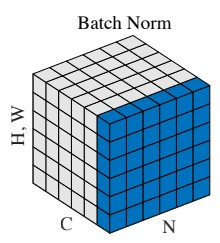

引用 : https://arxiv.org/abs/1803.08494


In [6]:
# 1つ目のチャンネルに対して、正規化後の平均を確認
print("{:.5f}".format(batch_normalized_tensor[:, 0, :, :].mean()))

0.00000


In [7]:
# 正解判定
answer_tensor = torch.tensor(
    [
        [
            [
                [-9.3485e-01, 3.6703e-01, 7.0092e-01, 7.8285e-03, 1.1773e00],
                [-4.4744e-01, -1.7178e00, -2.3143e00, -1.1014e-01, -3.7916e-01],
                [-1.7970e-01, 9.5536e-01, -8.5455e-01, 8.9911e-01, 6.0264e-01],
                [1.1049e00, -1.0713e00, 7.1333e-02, 2.0809e00, 1.5757e00],
                [-1.5909e00, 8.6450e-01, 1.9567e00, -2.1110e00, 2.7796e-01],
            ],
            [
                [3.3031e-01, -1.5816e00, -4.6982e-01, -4.5049e-01, 8.1268e-01],
                [1.7908e00, -9.2872e-01, 4.5793e-01, -5.9517e-01, -1.0796e00],
                [-2.1242e-01, 5.4590e-01, 5.9442e-01, 1.4104e00, 5.6494e-01],
                [1.0772e-01, 1.1327e00, 2.2271e-01, 2.0812e-01, 1.6791e00],
                [-5.8916e-01, 6.6031e-01, 1.0397e-01, 1.7829e00, 1.0480e00],
            ],
            [
                [-1.5731e00, -1.9687e-02, -8.4683e-01, -5.3470e-01, -2.3513e-01],
                [9.6314e-01, 1.3302e00, -7.3768e-01, -7.1465e-01, 3.8865e-01],
                [-9.0021e-01, -1.1497e00, -5.4230e-02, -4.3687e-01, 1.3108e00],
                [-6.8638e-01, -1.2416e00, 6.9583e-01, 1.7743e00, -1.1666e-01],
                [-9.3751e-01, 1.8310e-01, 1.4592e00, -1.6450e00, 3.4354e-01],
            ],
            [
                [-1.0423e00, -6.9731e-01, -1.3714e00, 6.7623e-01, -1.1574e00],
                [3.7459e-01, -2.5437e-01, 7.2045e-01, 1.7728e00, 2.0067e00],
                [2.1826e-01, 9.6296e-01, -6.3342e-02, -2.7265e-02, -8.2045e-01],
                [5.6587e-01, 8.6839e-01, -3.8891e-01, -7.9302e-01, -8.4738e-01],
                [2.5064e00, -7.0834e-01, -6.8353e-01, -6.9869e-01, -1.4126e-01],
            ],
        ],
        [
            [
                [-1.0512e00, -9.2990e-01, 3.8519e-01, 8.0283e-02, 1.3398e-01],
                [-1.0214e00, 1.0846e00, 4.6063e-01, 1.0357e00, 4.2261e-01],
                [1.4269e00, 9.9292e-02, 1.4989e-02, 1.6182e-02, -5.9512e-02],
                [-1.3692e00, -1.0380e00, -3.5018e-01, 4.1298e-01, -8.0140e-02],
                [-9.4499e-01, 1.3614e00, -8.4969e-01, -3.7396e-01, 2.0243e-01],
            ],
            [
                [5.7332e-01, -1.5040e00, -6.1423e-02, 3.7124e-01, 1.4559e-01],
                [-4.5681e-01, -7.6019e-02, 7.0262e-01, -1.7174e00, -1.0533e-02],
                [-4.9115e-03, 2.1221e00, 3.2676e-01, 4.5043e-01, -1.8865e-01],
                [6.4226e-01, -1.7082e00, -6.9360e-01, 1.2478e-01, -8.3108e-01],
                [-4.5671e-01, 8.1483e-02, -1.6655e00, -7.2279e-01, -2.9889e00],
            ],
            [
                [-6.0569e-01, 3.2061e-01, 1.1094e00, 3.8227e-01, 2.0204e00],
                [-2.5721e00, 1.3292e00, 1.5189e-01, 1.4300e00, -1.3188e-01],
                [-2.7482e-03, -6.0796e-02, -6.1083e-01, 8.4704e-01, -1.8677e00],
                [7.4112e-01, -1.4121e-01, 6.9117e-01, 1.8434e-01, 1.2715e-01],
                [1.5503e-01, 4.9732e-01, -7.0970e-01, 1.4871e00, -1.3901e00],
            ],
            [
                [-1.5139e00, 1.4060e00, 4.8270e-02, -1.0529e00, -3.2365e-01],
                [-1.3605e00, -1.5429e-01, -8.2934e-01, -1.2009e00, 1.6661e00],
                [1.8180e-01, -5.4411e-01, -2.9483e-01, -1.6562e00, -9.6889e-01],
                [2.1802e00, 1.5074e-01, -1.5629e-01, 1.0494e00, 1.1604e-01],
                [-1.5441e-01, 3.3438e-01, 1.4523e00, 5.8716e-01, 6.0296e-02],
            ],
        ],
    ],
)


if torch.isclose(batch_normalized_tensor, answer_tensor, atol=1e-04).all():
    print("バッチ正規化が正しく実装できています。")
else:
    print("バッチ正規化の実装が間違っています。もう一度解きなおしてください。")

バッチ正規化が正しく実装できています。


### レイヤー正規化（layer normalization）

* <font color="Red">問2. 入力テンソル`input_tensor`をレイヤー正規化する式を記述してください。</font>

In [8]:
# レイヤー正規化層のインスタンス化
layer_norm = torch.nn.LayerNorm(normalized_shape=[4, 5, 5])
layer_norm.train()

LayerNorm((4, 5, 5), eps=1e-05, elementwise_affine=True)

In [9]:
# レイヤー正規化の実行
layer_normalized_tensor = layer_norm(input_tensor) ### 問2 ###
layer_normalized_tensor

tensor([[[[-1.0878,  0.3683,  0.7418, -0.0334,  1.2746],
          [-0.5426, -1.9635, -2.6306, -0.1654, -0.4663],
          [-0.2432,  1.0263, -0.9980,  0.9634,  0.6318],
          [ 1.1936, -1.2404,  0.0376,  2.2852,  1.7202],
          [-1.8216,  0.9247,  2.1463, -2.4033,  0.2687]],

         [[ 0.1097, -1.7386, -0.6638, -0.6451,  0.5760],
          [ 1.5215, -1.1074,  0.2330, -0.7850, -1.2533],
          [-0.4150,  0.3181,  0.3650,  1.1538,  0.3365],
          [-0.1055,  0.8853,  0.0057, -0.0085,  1.4135],
          [-0.7792,  0.4287, -0.1091,  1.5139,  0.8034]],

         [[-1.5640, -0.0077, -0.8364, -0.5237, -0.2235],
          [ 0.9770,  1.3447, -0.7270, -0.7039,  0.4014],
          [-0.8899, -1.1398, -0.0423, -0.4257,  1.3252],
          [-0.6756, -1.2318,  0.7092,  1.7896, -0.1048],
          [-0.9272,  0.1955,  1.4740, -1.6361,  0.3562]],

         [[-0.7812, -0.5186, -1.0316,  0.5268, -0.8688],
          [ 0.2972, -0.1815,  0.5604,  1.3614,  1.5394],
          [ 0.1782,  0.74

レイヤー正規化は、各サンプルごとに正規化する。

以下で、1つ目のサンプルを取り出した場合に正規化（すなわち、平均がほぼ 0）できているかを確認する。



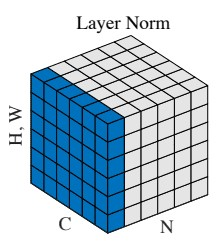

引用 : https://arxiv.org/abs/1803.08494

In [10]:
# 1つ目のサンプルに対して、正規化後の平均を確認
print("{:.5f}".format(layer_normalized_tensor[0, :, :, :].mean()))

-0.00000


In [11]:
# 正解判定
answer_tensor = torch.tensor(
    [
        [
            [
                [-1.0878, 0.3683, 0.7418, -0.0334, 1.2746],
                [-0.5426, -1.9635, -2.6306, -0.1654, -0.4663],
                [-0.2432, 1.0263, -0.9980, 0.9634, 0.6318],
                [1.1936, -1.2404, 0.0376, 2.2852, 1.7202],
                [-1.8216, 0.9247, 2.1463, -2.4033, 0.2687],
            ],
            [
                [0.1097, -1.7386, -0.6638, -0.6451, 0.5760],
                [1.5215, -1.1074, 0.2330, -0.7850, -1.2533],
                [-0.4150, 0.3181, 0.3650, 1.1538, 0.3365],
                [-0.1055, 0.8853, 0.0057, -0.0085, 1.4135],
                [-0.7792, 0.4287, -0.1091, 1.5139, 0.8034],
            ],
            [
                [-1.5640, -0.0077, -0.8364, -0.5237, -0.2235],
                [0.9770, 1.3447, -0.7270, -0.7039, 0.4014],
                [-0.8899, -1.1398, -0.0423, -0.4257, 1.3252],
                [-0.6756, -1.2318, 0.7092, 1.7896, -0.1048],
                [-0.9272, 0.1955, 1.4740, -1.6361, 0.3562],
            ],
            [
                [-0.7812, -0.5186, -1.0316, 0.5268, -0.8688],
                [0.2972, -0.1815, 0.5604, 1.3614, 1.5394],
                [0.1782, 0.7450, -0.0361, -0.0086, -0.6123],
                [0.4428, 0.6730, -0.2839, -0.5914, -0.6328],
                [1.9197, -0.5270, -0.5081, -0.5197, -0.0954],
            ],
        ],
        [
            [
                [-1.1675, -1.0241, 0.5314, 0.1707, 0.2342],
                [-1.1322, 1.3586, 0.6206, 1.3008, 0.5756],
                [1.7634, 0.1932, 0.0935, 0.0949, 0.0054],
                [-1.5437, -1.1519, -0.3384, 0.5642, -0.0190],
                [-1.0419, 1.6859, -0.9292, -0.3665, 0.3152],
            ],
            [
                [0.4848, -1.6387, -0.1641, 0.2782, 0.0475],
                [-0.5683, -0.1790, 0.6169, -1.8569, -0.1121],
                [-0.1063, 2.0680, 0.2327, 0.3592, -0.2941],
                [0.5552, -1.8475, -0.8103, 0.0263, -0.9509],
                [-0.5682, -0.0180, -1.8039, -0.8402, -3.1567],
            ],
            [
                [-0.5086, 0.4728, 1.3085, 0.5381, 2.2736],
                [-2.5919, 1.5413, 0.2940, 1.6481, -0.0066],
                [0.1302, 0.0687, -0.5140, 1.0305, -1.8456],
                [0.9183, -0.0165, 0.8654, 0.3284, 0.2678],
                [0.2974, 0.6600, -0.6188, 1.7086, -1.3396],
            ],
            [
                [-1.0853, 1.2648, 0.1720, -0.7142, -0.1273],
                [-0.9618, 0.0090, -0.5343, -0.8333, 1.4741],
                [0.2795, -0.3047, -0.1041, -1.1998, -0.6466],
                [1.8879, 0.2545, 0.0074, 0.9778, 0.2266],
                [0.0089, 0.4023, 1.3020, 0.6058, 0.1817],
            ],
        ],
    ],
)

if torch.isclose(layer_normalized_tensor, answer_tensor, atol=1e-04).all():
    print("レイヤー正規化が正しく実装できています。")
else:
    print("レイヤー正規化の実装が間違っています。もう一度解きなおしてください。")

レイヤー正規化が正しく実装できています。


### インスタンス正規化（instance normalization）

* <font color="Red">問3. 入力テンソル`input_tensor`をインスタンス正規化する式を記述してください。</font>

In [12]:
# インスタンス正規化のインスタンス化
instance_norm = torch.nn.InstanceNorm2d(4)
instance_norm.train()

InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)

In [13]:
# インスタンス正規化の実行
instance_normalized_tensor = instance_norm(input_tensor) ### 問3 ###
instance_normalized_tensor

tensor([[[[-0.8194,  0.2780,  0.5594, -0.0248,  0.9610],
          [-0.4085, -1.4793, -1.9821, -0.1242, -0.3510],
          [-0.1829,  0.7739, -0.7517,  0.7265,  0.4766],
          [ 0.8999, -0.9344,  0.0287,  1.7226,  1.2968],
          [-1.3724,  0.6973,  1.6179, -1.8107,  0.2029]],

         [[ 0.0322, -2.1326, -0.8738, -0.8519,  0.5784],
          [ 1.6860, -1.3934,  0.1767, -1.0157, -1.5642],
          [-0.5823,  0.2764,  0.3313,  1.2553,  0.2979],
          [-0.2198,  0.9408, -0.0896, -0.1061,  1.5595],
          [-1.0089,  0.4059, -0.2240,  1.6770,  0.8449]],

         [[-1.5140,  0.1217, -0.7493, -0.4206, -0.1052],
          [ 1.1566,  1.5431, -0.6343, -0.6101,  0.5517],
          [-0.8055, -1.0682,  0.0853, -0.3176,  1.5226],
          [-0.5803, -1.1649,  0.8751,  2.0107,  0.0196],
          [-0.8448,  0.3352,  1.6789, -1.5898,  0.5042]],

         [[-1.0795, -0.7351, -1.4079,  0.6360, -1.1944],
          [ 0.3349, -0.2929,  0.6801,  1.7306,  1.9640],
          [ 0.1788,  0.92

インスタンス正規化は、各チャンネルごとに正規化する。

以下で、1つ目のサンプルの1つ目のチャンネルを取り出した場合に、正規化（すなわち、平均がほぼ 0）できているかを確認する。



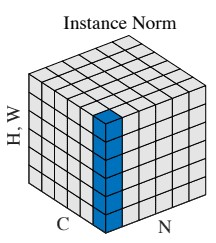

引用 : https://arxiv.org/abs/1803.08494


In [14]:
#  1つ目のサンプルの1つ目のチャンネルに対して、正規化後の平均を確認
print("{:.5f}".format(instance_normalized_tensor[0, 0, :, :].mean()))

0.00000


In [15]:
# 正解判定
answer_tensor = torch.tensor(
    [
        [
            [
                [-0.8194, 0.2780, 0.5594, -0.0248, 0.9610],
                [-0.4085, -1.4793, -1.9821, -0.1242, -0.3510],
                [-0.1829, 0.7739, -0.7517, 0.7265, 0.4766],
                [0.8999, -0.9344, 0.0287, 1.7226, 1.2968],
                [-1.3724, 0.6973, 1.6179, -1.8107, 0.2029],
            ],
            [
                [0.0322, -2.1326, -0.8738, -0.8519, 0.5784],
                [1.6860, -1.3934, 0.1767, -1.0157, -1.5642],
                [-0.5823, 0.2764, 0.3313, 1.2553, 0.2979],
                [-0.2198, 0.9408, -0.0896, -0.1061, 1.5595],
                [-1.0089, 0.4059, -0.2240, 1.6770, 0.8449],
            ],
            [
                [-1.5140, 0.1217, -0.7493, -0.4206, -0.1052],
                [1.1566, 1.5431, -0.6343, -0.6101, 0.5517],
                [-0.8055, -1.0682, 0.0853, -0.3176, 1.5226],
                [-0.5803, -1.1649, 0.8751, 2.0107, 0.0196],
                [-0.8448, 0.3352, 1.6789, -1.5898, 0.5042],
            ],
            [
                [-1.0795, -0.7351, -1.4079, 0.6360, -1.1944],
                [0.3349, -0.2929, 0.6801, 1.7306, 1.9640],
                [0.1788, 0.9222, -0.1023, -0.0663, -0.8580],
                [0.5258, 0.8278, -0.4272, -0.8306, -0.8849],
                [2.4628, -0.7461, -0.7213, -0.7365, -0.1800],
            ],
        ],
        [
            [
                [-1.3204, -1.1625, 0.5501, 0.1530, 0.2230],
                [-1.2816, 1.4609, 0.6483, 1.3973, 0.5988],
                [1.9067, 0.1778, 0.0680, 0.0696, -0.0290],
                [-1.7346, -1.3032, -0.4075, 0.5863, -0.0559],
                [-1.1821, 1.8213, -1.0580, -0.4385, 0.3121],
            ],
            [
                [0.8591, -1.1800, 0.2360, 0.6607, 0.4392],
                [-0.1521, 0.2217, 0.9860, -1.3895, 0.2860],
                [0.2915, 2.3794, 0.6170, 0.7384, 0.1111],
                [0.9267, -1.3805, -0.3846, 0.4188, -0.5195],
                [-0.1520, 0.3763, -1.3386, -0.4132, -2.6376],
            ],
            [
                [-0.7192, 0.1799, 0.9455, 0.2398, 1.8297],
                [-2.6277, 1.1589, 0.0161, 1.2567, -0.2593],
                [-0.1339, -0.1903, -0.7241, 0.6909, -1.9441],
                [0.5881, -0.2683, 0.5396, 0.0476, -0.0079],
                [0.0192, 0.3514, -0.8201, 1.3121, -1.4805],
            ],
            [
                [-1.4798, 1.4500, 0.0877, -1.0172, -0.2855],
                [-1.3258, -0.1156, -0.7929, -1.1657, 1.7109],
                [0.2216, -0.5067, -0.2566, -1.6225, -0.9329],
                [2.2267, 0.1905, -0.1176, 1.0922, 0.1557],
                [-0.1157, 0.3747, 1.4964, 0.6284, 0.0997],
            ],
        ],
    ]
)

if torch.isclose(instance_normalized_tensor, answer_tensor, atol=1e-04).all():
    print("インスタンス正規化が正しく実装できています。")
else:
    print("インスタンス正規化の実装が間違っています。もう一度解きなおしてください。")

インスタンス正規化が正しく実装できています。


### グループ正規化（group normalization）

* <font color="Red">問4. 入力テンソル`input_tensor`をグループ正規化する式を記述してください。</font>

In [16]:
# グループ正規化層のインスタンス化
group_norm = torch.nn.GroupNorm(2,4)
group_norm.train()

# 正規化の実行
group_normalized_tensor =  group_norm(input_tensor) ### 問4 ###
group_normalized_tensor

tensor([[[[-1.0108e+00,  2.9335e-01,  6.2783e-01, -6.6493e-02,  1.1051e+00],
          [-5.2257e-01, -1.7952e+00, -2.3927e+00, -1.8468e-01, -4.5417e-01],
          [-2.5435e-01,  8.8272e-01, -9.3040e-01,  8.2636e-01,  5.2937e-01],
          [ 1.0325e+00, -1.1476e+00, -2.8760e-03,  2.0102e+00,  1.5042e+00],
          [-1.6681e+00,  7.9169e-01,  1.8858e+00, -2.1891e+00,  2.0411e-01]],

         [[ 6.1680e-02, -1.5937e+00, -6.3110e-01, -6.1437e-01,  4.7933e-01],
          [ 1.3262e+00, -1.0284e+00,  1.7218e-01, -7.3964e-01, -1.1591e+00],
          [-4.0823e-01,  2.4835e-01,  2.9036e-01,  9.9689e-01,  2.6483e-01],
          [-1.3105e-01,  7.5643e-01, -3.1482e-02, -4.4120e-02,  1.2295e+00],
          [-7.3443e-01,  3.4740e-01, -1.3429e-01,  1.3194e+00,  6.8308e-01]],

         [[-1.7587e+00,  3.8227e-02, -9.1856e-01, -5.5751e-01, -2.1099e-01],
          [ 1.1751e+00,  1.5997e+00, -7.9230e-01, -7.6566e-01,  5.1057e-01],
          [-9.8031e-01, -1.2689e+00, -1.7304e-03, -4.4435e-01,  1.5772e+

グループ正規化は、チャネルを任意の個数のグループ分けて、サンプル、グループごとに正規化する。グループ数＝チャンネル数の場合インスタンス正規化と同一に、グループ数＝１の時はレイヤー正規化と同一の処理となる。

以下で、1つ目のサンプルの1つ目のグループを取り出した場合に、正規化（すなわち、平均がほぼ 0）できているかを確認する。

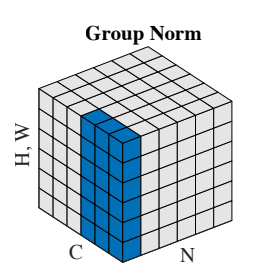

引用 : https://arxiv.org/abs/1803.08494

In [17]:
# 1つ目のサンプルの1つ目のグループに対して、正規化後の平均を確認
print("{:.5f}".format(group_normalized_tensor[0, 0:2, :, :].mean()))

0.00000


In [18]:
# 正解判定
answer_tensor = torch.tensor(
    [
        [
            [
                [-1.0108e00, 2.9335e-01, 6.2783e-01, -6.6493e-02, 1.1051e00],
                [-5.2257e-01, -1.7952e00, -2.3927e00, -1.8468e-01, -4.5417e-01],
                [-2.5435e-01, 8.8272e-01, -9.3040e-01, 8.2636e-01, 5.2937e-01],
                [1.0325e00, -1.1476e00, -2.8760e-03, 2.0102e00, 1.5042e00],
                [-1.6681e00, 7.9169e-01, 1.8858e00, -2.1891e00, 2.0411e-01],
            ],
            [
                [6.1680e-02, -1.5937e00, -6.3110e-01, -6.1437e-01, 4.7933e-01],
                [1.3262e00, -1.0284e00, 1.7218e-01, -7.3964e-01, -1.1591e00],
                [-4.0823e-01, 2.4835e-01, 2.9036e-01, 9.9689e-01, 2.6483e-01],
                [-1.3105e-01, 7.5643e-01, -3.1482e-02, -4.4120e-02, 1.2295e00],
                [-7.3443e-01, 3.4740e-01, -1.3429e-01, 1.3194e00, 6.8308e-01],
            ],
            [
                [-1.7587e00, 3.8227e-02, -9.1856e-01, -5.5751e-01, -2.1099e-01],
                [1.1751e00, 1.5997e00, -7.9230e-01, -7.6566e-01, 5.1057e-01],
                [-9.8031e-01, -1.2689e00, -1.7304e-03, -4.4435e-01, 1.5772e00],
                [-7.3297e-01, -1.3752e00, 8.6589e-01, 2.1134e00, -7.3941e-02],
                [-1.0235e00, 2.7280e-01, 1.7489e00, -1.8419e00, 4.5839e-01],
            ],
            [
                [-8.5483e-01, -5.5167e-01, -1.1440e00, 6.5532e-01, -9.5599e-01],
                [3.9025e-01, -1.6244e-01, 6.9417e-01, 1.6189e00, 1.8244e00],
                [2.5288e-01, 9.0728e-01, 5.4246e-03, 3.7127e-02, -6.5988e-01],
                [5.5834e-01, 8.2418e-01, -2.8066e-01, -6.3577e-01, -6.8355e-01],
                [2.2635e00, -5.6136e-01, -5.3957e-01, -5.5288e-01, -6.3043e-02],
            ],
        ],
        [
            [
                [-9.7678e-01, -8.3357e-01, 7.1918e-01, 3.5917e-01, 4.2258e-01],
                [-9.4156e-01, 1.5450e00, 8.0825e-01, 1.4873e00, 7.6336e-01],
                [1.9492e00, 3.8162e-01, 2.8208e-01, 2.8349e-01, 1.9412e-01],
                [-1.3523e00, -9.6118e-01, -1.4908e-01, 7.5199e-01, 1.6976e-01],
                [-8.5138e-01, 1.8718e00, -7.3886e-01, -1.7716e-01, 5.0340e-01],
            ],
            [
                [6.7268e-01, -1.4472e00, 2.4932e-02, 4.6646e-01, 2.3618e-01],
                [-3.7855e-01, 1.0036e-02, 8.0462e-01, -1.6650e00, 7.6864e-02],
                [8.2601e-02, 2.2532e00, 4.2107e-01, 5.4728e-01, -1.0490e-01],
                [7.4303e-01, -1.6556e00, -6.2020e-01, 2.1495e-01, -7.6050e-01],
                [-3.7845e-01, 1.7077e-01, -1.6121e00, -6.4999e-01, -2.9625e00],
            ],
            [
                [-7.2534e-01, 2.9499e-01, 1.1638e00, 3.6291e-01, 2.1673e00],
                [-2.8914e00, 1.4060e00, 1.0914e-01, 1.5170e00, -2.0344e-01],
                [-6.1197e-02, -1.2514e-01, -7.3100e-01, 8.7486e-01, -2.1155e00],
                [7.5819e-01, -2.1371e-01, 7.0316e-01, 1.4488e-01, 8.1884e-02],
                [1.1260e-01, 4.8964e-01, -8.3991e-01, 1.5799e00, -1.5894e00],
            ],
            [
                [-1.3249e00, 1.1185e00, -1.7696e-02, -9.3918e-01, -3.2891e-01],
                [-1.1965e00, -1.8719e-01, -7.5207e-01, -1.0630e00, 1.3361e00],
                [9.4043e-02, -5.1339e-01, -3.0480e-01, -1.4440e00, -8.6884e-01],
                [1.7663e00, 6.8048e-02, -1.8887e-01, 8.2003e-01, 3.9012e-02],
                [-1.8730e-01, 2.2172e-01, 1.1571e00, 4.3324e-01, -7.6331e-03],
            ],
        ],
    ],
)

if torch.isclose(group_normalized_tensor, answer_tensor, atol=1e-04).all():
    print("グループ正規化が正しく実装できています。")
else:
    print("グループ正規化の実装が間違っています。もう一度解きなおしてください。")

グループ正規化が正しく実装できています。


## 2. im2col, col2im

画像データに対する畳み込みなどの演算を行列積として実装するため、  
四次元配列である画像を二次元配列へと変換する関数 `im2col`、  
逆伝播用の逆変換 `col2im` を実装します。

画像データにフィルタをそのまま適用してしまうと計算に時間がかかることが知られています。

(numpyは行列計算が高速にできるようになっており、逆にfor文には時間がかかるため)

そこで、今回はこの処理を行列演算で行っていきます。  
im2col, 畳み込み、col2imの処理の流れとしては、
- 高次元配列を二次元配列に変換する。(①フィルタの行列変換、②画像データの行列変換)
- 行列積を求める。
- 行列を高次元配列に変換する。

となります。


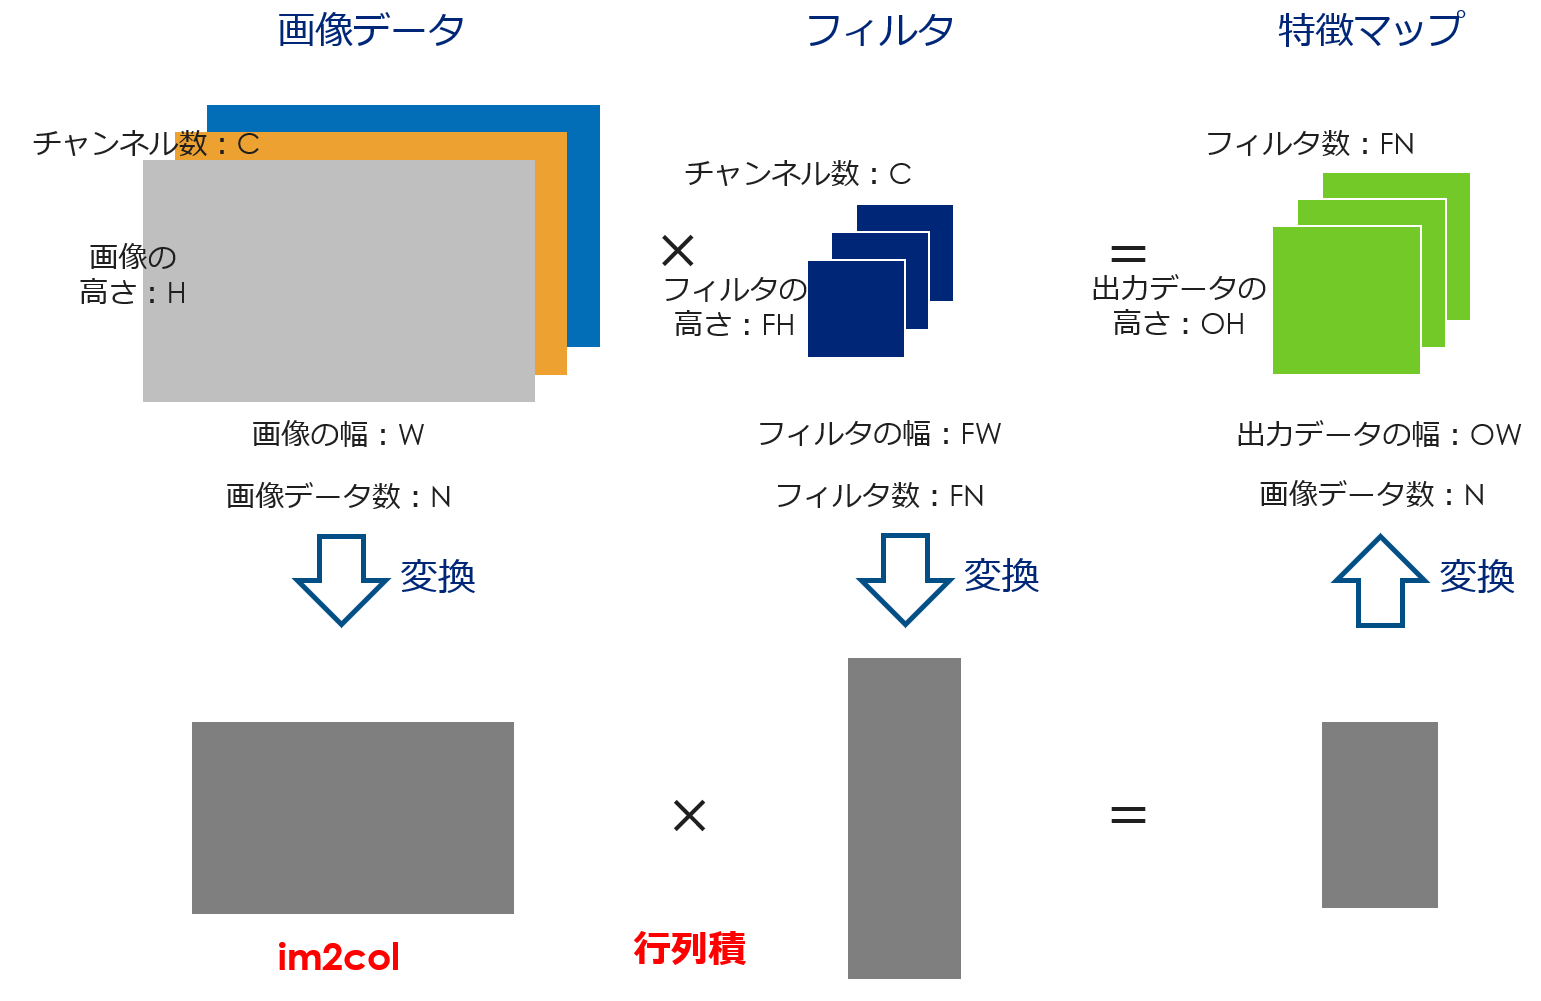

### ①フィルタの行列変換

画像データだけではなく、フィルタのデータも多次元です。  
im2colを考える前に、このフィルタをどのように行列化するかを考えていきます。

まずは配列の表記にして考えてみましょう。  
ここでは元々のフィルタをfilter_org(FN, C, FH, FW)と記載することとします。

フィルタの数がFN個あり、これらを画像データ群に適用させる必要があります。

画像データの配列と行列積を行うためには、縦方向に「一つのフィルタの情報」を格納し、そのフィルタ情報を横に並べる形をとります。

行列の縦方向は「フィルタのデータ（C×FH×FW）」が入ります。  
フィルタの行列としてはfilter_col(C×FH×FW, FN)となります。

また、よくある間違い例として  
<font color="Red">filter_org(FN, C, FH, FW)から変換せずに、いきなりreshapeを行ってしまう</font>  
という例があります。

numpy.reshapeは先頭からデータを取ってくるので、  
filter_org(FN, C, FH, FW)はFN→C→FH→FWの順番でデータを取ってきます。

しかし、filter_col(C×FH×FW, FN)の順番はC→FH→FW→FNとなっているため、これでは上手くいきません。

あらかじめfilter_org(FN, C, FH, FW)をfilter_org(C, FH, FW, FN)に変換する必要があります。

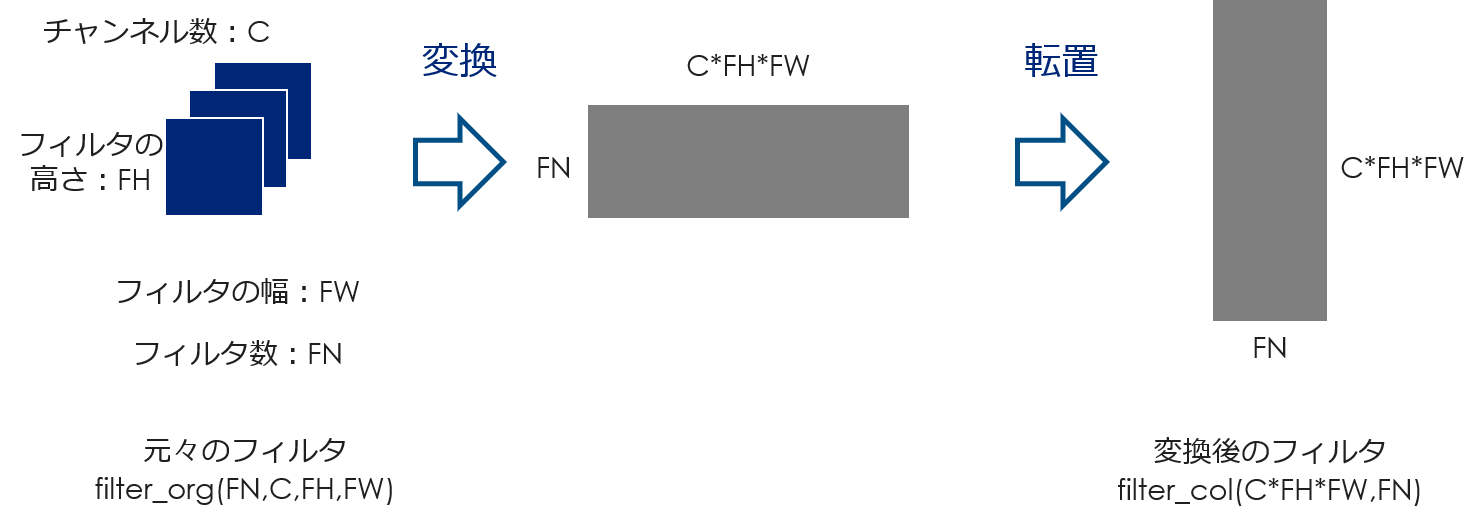

### ②画像データの行列変換

続いてどのようなサイズの行列にすべきかを考えます。  
フィルタのサイズはfilter_col(C×FH×FW, FN)です。

行列変換後の画像ファイルをim_colとすると、im_colとfilter_colとの行列積を求めるためには、im_colの列のサイズはfilter_colの行のサイズと同じにする必要があります。  
つまり、C×FH×FWです。

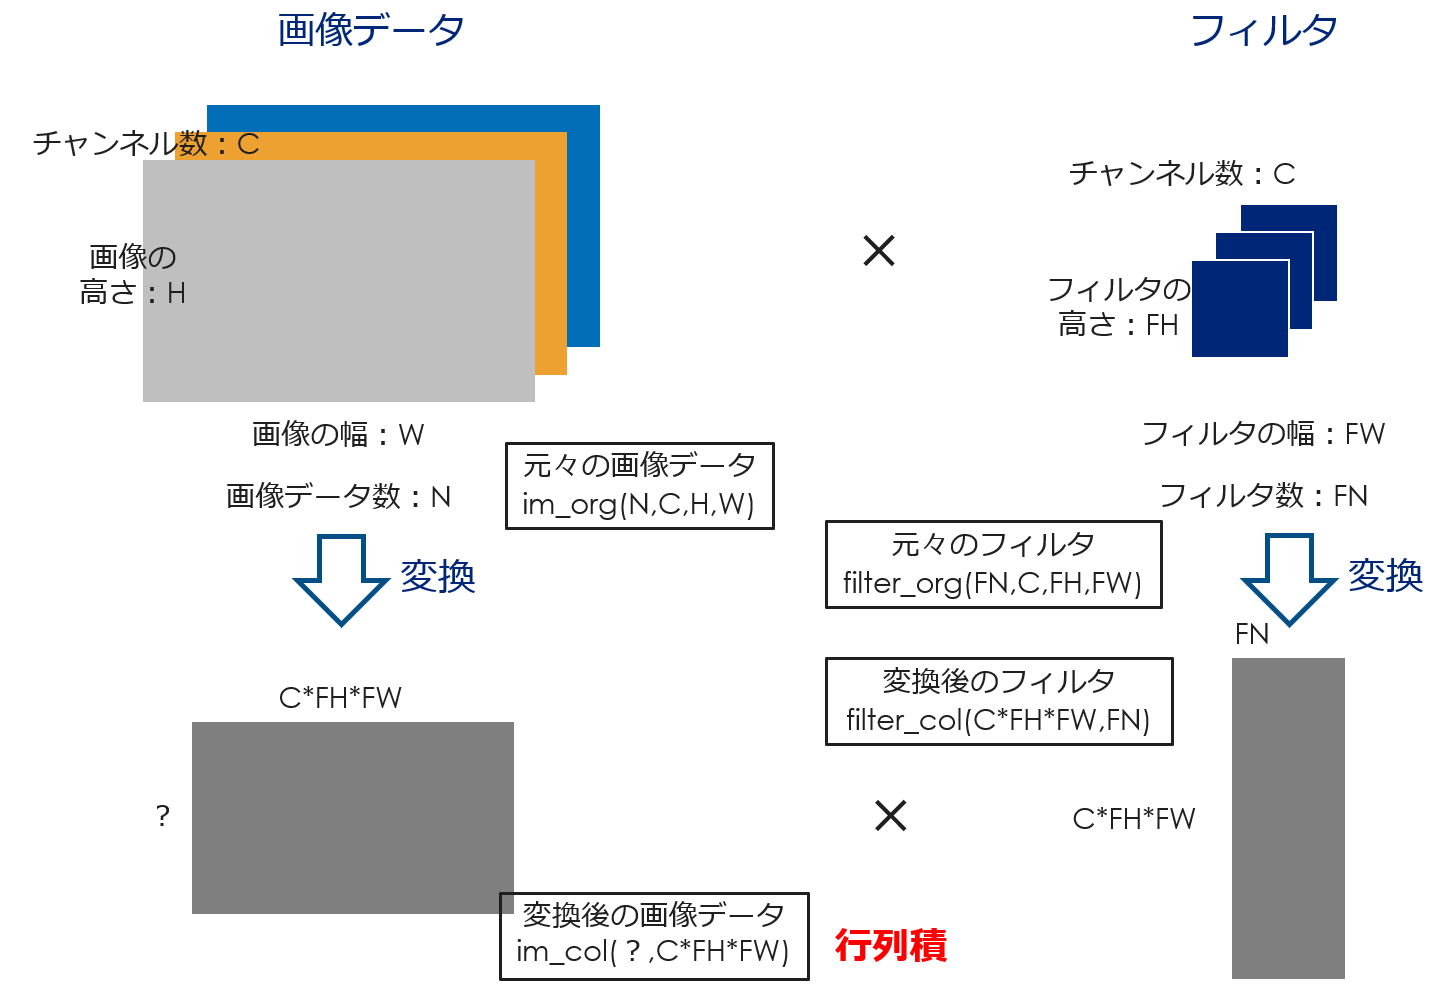

次に、im_colの縦方向にはどのような値を入れるのかを考えます。  

filter_colの行列積を取ることを考えると、  
1列目にはフィルタ "0" が掛け合わされます。

2列目にはフィルタ"1”、3列目は、・・・・というふうにつながります。

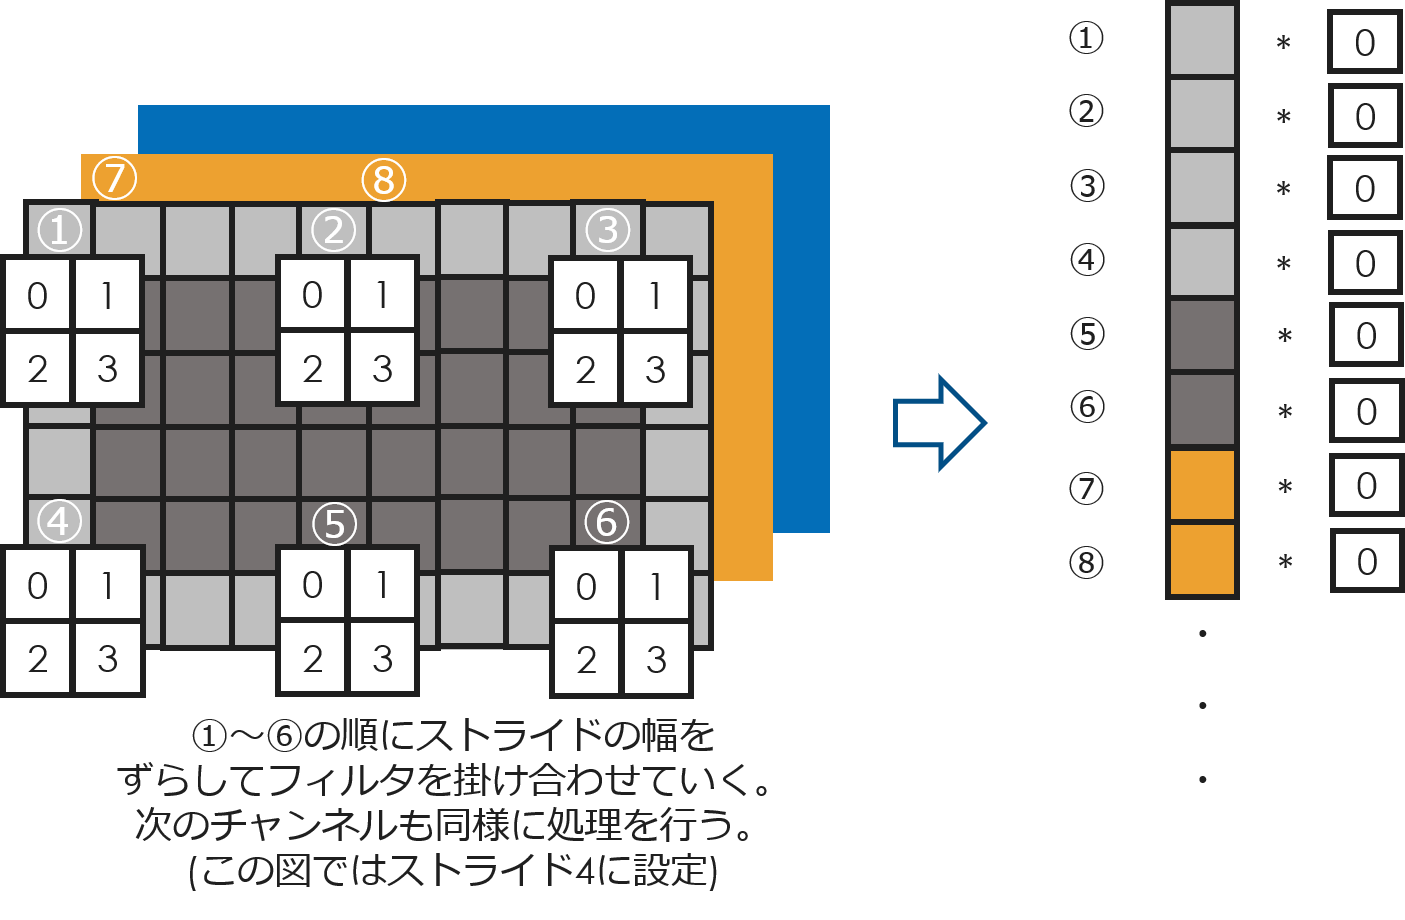

ここでOHは出力データの高さ、OWは出力データの幅だったので、値の個数は（N×OH×OW）となります。<br>

Nは画像データの数です。OH,OWですが、これは畳み込み後のデータサイズを表します。<br>

結論として、画像データの変換後サイズは　im_col(N×OH×OW, C×FH×FW) となります。<br>

im2colの説明は以上です。それでは実際にim2colを実装していきましょう。<br>

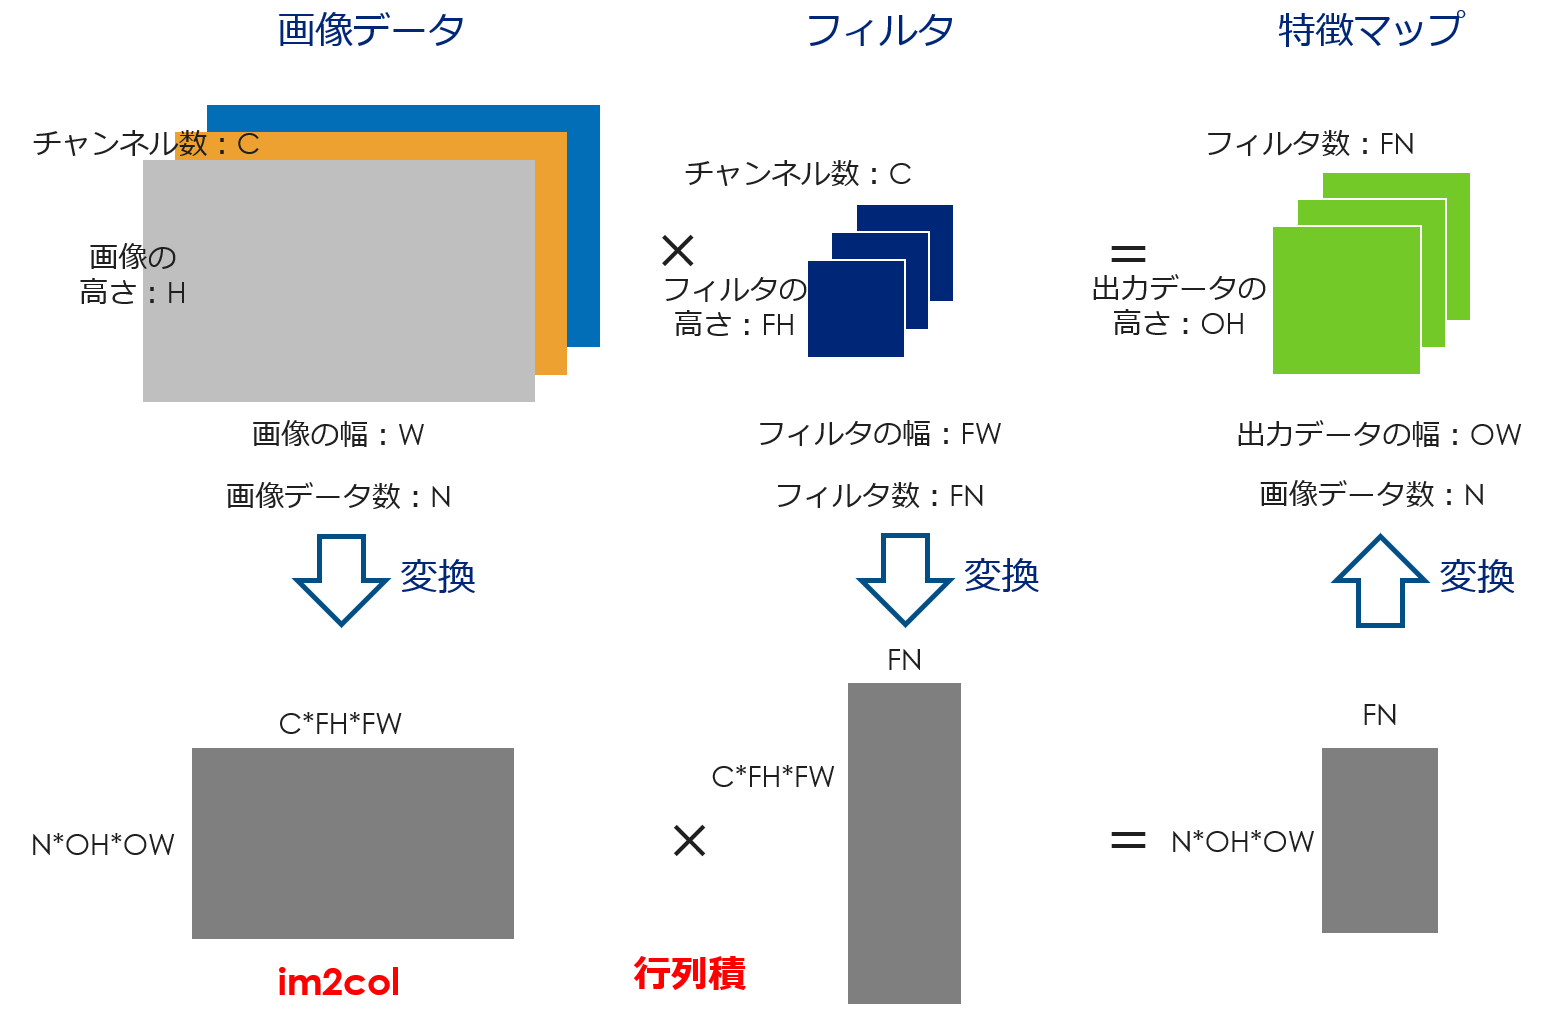

* <font color="Red">問5. 画像データを二次元配列へと変換する関数 `im2col` を完成させてください。</font>
```
引数:
    input_data: 入力画像データ。形状は [N, C, H, W] でそれぞれバッチサイズ、チャンネル数、高さ、幅
    filter_h: フィルタの高さ
    filter_w: フィルタの幅
    stride: ストライド数
    pad: パディング数
返値:
    col: 行列変換後のデータ。形状は [N*out_h*out_w, C*filter_h*filter_w] で、out_hとout_wはそれぞれフィルタ適用後の出力画像サイズ
```
  * <font color="Red">問5-1. `H`, `filter_h`, `pad`, `stride`の変数を用いて、フィルタ適用後の出力画像の高さを算出する式を記述してください。</font>
  * <font color="Red">問5-2. `W`, `filter_w`, `pad`, `stride`の変数を用いて、フィルタ適用後の出力画像の幅を算出する式を記述してください。</font>
  * <font color="Red">問5-3. `input_data`に対して、パディング処理をする式を記述してください。</font>
  * <font color="Red">問5-4. 画像データを行列に変換する処理を記述しましょう。</font>

In [19]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """画像データを行列に変換する関数

    畳み込み層の計算を効率的に行うために、入力データを2次元の行列に変換します。この関数は、畳み込み層の実装において重要な役割を果たします。

    Args:
        input_data (ndarray): 入力データ。4次元配列 (バッチサイズ, チャネル数, 高さ, 幅)。
        filter_h (int): フィルタの高さ。
        filter_w (int): フィルタの幅。
        stride (int, optional): ストライドの大きさ。デフォルトは1。
        pad (int, optional): パディングの大きさ。デフォルトは0。

    Returns:
        ndarray: 2次元化された入力データ。

    Examples:
        >>> input_data = np.random.rand(1, 1, 28, 28)  # 1枚の28x28の画像データ
        >>> filter_h, filter_w, stride, pad = 5, 5, 1, 0
        >>> col = im2col(input_data, filter_h, filter_w, stride, pad)
        >>> print(col.shape)
        (576, 25)

    Note:
        - フィルタを適用した際の出力画像サイズを計算し、そのサイズに合わせて入力データを変換します。
        - 必要に応じて入力データにパディングを施します。
        - この関数は、畳み込み層の順伝播および逆伝播の計算を効率化するために使用されます。
    """
    N, C, H, W = input_data.shape

    # フィルタを適用した際、出力の画像サイズがどうなるかを計算
    out_h = 1 + (H + 2*pad - filter_h) // stride ### 問5-1 ###
    out_w = 1 + (W + 2*pad - filter_w) // stride ### 問5-2 ###

    # パディング処理
    img = np.pad(input_data, ((0,0), (0,0), (pad, pad), (pad, pad)), 'constant')  ### 問5-3 ###
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h

        for x in range(filter_w):
            x_max = x + stride * out_w
            # 画像データを行列に変換する処理
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride] ### 問5-4 ###

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

### 確認用セル
以下のセルを実行して`im2col`の実装が正しいか確認してください。

In [20]:
dummy_imgs = np.arange(135).reshape(5, 3, 3, 3)
dummy_kernels = np.arange(48).reshape(4, 3, 2, 2)
dummy_conv = np.dot(im2col(dummy_imgs, 2, 2, pad=1), dummy_kernels.reshape(4, 12).T)

In [21]:
ans = np.array(
    [
        [261.0, 585.0, 909.0, 1233.0],
        [516.0, 1200.0, 1884.0, 2568.0],
        [555.0, 1311.0, 2067.0, 2823.0],
        [270.0, 666.0, 1062.0, 1458.0],
        [531.0, 1287.0, 2043.0, 2799.0],
        [1035.0, 2619.0, 4203.0, 5787.0],
        [1101.0, 2829.0, 4557.0, 6285.0],
        [528.0, 1428.0, 2328.0, 3228.0],
        [639.0, 1611.0, 2583.0, 3555.0],
        [1233.0, 3249.0, 5265.0, 7281.0],
        [1299.0, 3459.0, 5619.0, 7779.0],
        [618.0, 1734.0, 2850.0, 3966.0],
        [297.0, 837.0, 1377.0, 1917.0],
        [564.0, 1680.0, 2796.0, 3912.0],
        [591.0, 1779.0, 2967.0, 4155.0],
        [276.0, 888.0, 1500.0, 2112.0],
        [828.0, 2124.0, 3420.0, 4716.0],
        [1569.0, 4197.0, 6825.0, 9453.0],
        [1608.0, 4308.0, 7008.0, 9708.0],
        [756.0, 2124.0, 3492.0, 4860.0],
        [1503.0, 4203.0, 6903.0, 9603.0],
        [2817.0, 8289.0, 13761.0, 19233.0],
        [2883.0, 8499.0, 14115.0, 19731.0],
        [1338.0, 4182.0, 7026.0, 9870.0],
        [1611.0, 4527.0, 7443.0, 10359.0],
        [3015.0, 8919.0, 14823.0, 20727.0],
        [3081.0, 9129.0, 15177.0, 21225.0],
        [1428.0, 4488.0, 7548.0, 10608.0],
        [702.0, 2214.0, 3726.0, 5238.0],
        [1293.0, 4353.0, 7413.0, 10473.0],
        [1320.0, 4452.0, 7584.0, 10716.0],
        [600.0, 2184.0, 3768.0, 5352.0],
        [1395.0, 3663.0, 5931.0, 8199.0],
        [2622.0, 7194.0, 11766.0, 16338.0],
        [2661.0, 7305.0, 11949.0, 16593.0],
        [1242.0, 3582.0, 5922.0, 8262.0],
        [2475.0, 7119.0, 11763.0, 16407.0],
        [4599.0, 13959.0, 23319.0, 32679.0],
        [4665.0, 14169.0, 23673.0, 33177.0],
        [2148.0, 6936.0, 11724.0, 16512.0],
        [2583.0, 7443.0, 12303.0, 17163.0],
        [4797.0, 14589.0, 24381.0, 34173.0],
        [4863.0, 14799.0, 24735.0, 34671.0],
        [2238.0, 7242.0, 12246.0, 17250.0],
        [1107.0, 3591.0, 6075.0, 8559.0],
        [2022.0, 7026.0, 12030.0, 17034.0],
        [2049.0, 7125.0, 12201.0, 17277.0],
        [924.0, 3480.0, 6036.0, 8592.0],
        [1962.0, 5202.0, 8442.0, 11682.0],
        [3675.0, 10191.0, 16707.0, 23223.0],
        [3714.0, 10302.0, 16890.0, 23478.0],
        [1728.0, 5040.0, 8352.0, 11664.0],
        [3447.0, 10035.0, 16623.0, 23211.0],
        [6381.0, 19629.0, 32877.0, 46125.0],
        [6447.0, 19839.0, 33231.0, 46623.0],
        [2958.0, 9690.0, 16422.0, 23154.0],
        [3555.0, 10359.0, 17163.0, 23967.0],
        [6579.0, 20259.0, 33939.0, 47619.0],
        [6645.0, 20469.0, 34293.0, 48117.0],
        [3048.0, 9996.0, 16944.0, 23892.0],
        [1512.0, 4968.0, 8424.0, 11880.0],
        [2751.0, 9699.0, 16647.0, 23595.0],
        [2778.0, 9798.0, 16818.0, 23838.0],
        [1248.0, 4776.0, 8304.0, 11832.0],
        [2529.0, 6741.0, 10953.0, 15165.0],
        [4728.0, 13188.0, 21648.0, 30108.0],
        [4767.0, 13299.0, 21831.0, 30363.0],
        [2214.0, 6498.0, 10782.0, 15066.0],
        [4419.0, 12951.0, 21483.0, 30015.0],
        [8163.0, 25299.0, 42435.0, 59571.0],
        [8229.0, 25509.0, 42789.0, 60069.0],
        [3768.0, 12444.0, 21120.0, 29796.0],
        [4527.0, 13275.0, 22023.0, 30771.0],
        [8361.0, 25929.0, 43497.0, 61065.0],
        [8427.0, 26139.0, 43851.0, 61563.0],
        [3858.0, 12750.0, 21642.0, 30534.0],
        [1917.0, 6345.0, 10773.0, 15201.0],
        [3480.0, 12372.0, 21264.0, 30156.0],
        [3507.0, 12471.0, 21435.0, 30399.0],
        [1572.0, 6072.0, 10572.0, 15072.0],
    ]
)

if (dummy_conv == ans).all():
    print("im2col の実装に問題はありません。先に進んでください。")
else:
    print("im2col の実装に問題があります。解き直してください。")

im2col の実装に問題はありません。先に進んでください。


* <font color="Red">問6. 二次元配列での勾配を四次元配列の画像データでの勾配へと変換する関数 `col2im` を完成させてください。</font>

```
引数:
    col: 行列データ
    input_shape: 入力画像データの形状。 tuple(N, C, H, W) でそれぞれバッチサイズ、チャンネル数、高さ、幅
    filter_h: フィルタの高さ
    filter_w: フィルタの幅
    stride: ストライド数
    pad: パディング数
返値:
    img: 行列から変換した画像データ
```

  * <font color="Red">問6-1. `H`, `filter_h`, `pad`, `stride`の変数を用いて、フィルタ適用後の出力画像の高さを算出する式を記述してください。</font>
  * <font color="Red">問6-2. `W`, `filter_w`, `pad`, `stride`の変数を用いて、フィルタ適用後の出力画像の幅を算出する式を記述してください。</font>
  * <font color="Red">問6-3. 行列を画像データに変換する処理を記述しましょう。</font>

`col2im` の実装問題は、問5で実装したim2colの逆変換となります。

In [1]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    col2im変換を行う関数

    この関数は、畳み込み層の逆伝播において用いられるcol2im変換を実行します。col形式のデータを元の画像データの形に戻します。

    Args:
        col (ndarray): col形式のデータ。
        input_shape (tuple): 入力データの形状 (N, C, H, W)。
        filter_h (int): フィルタの高さ。
        filter_w (int): フィルタの幅。
        stride (int, optional): ストライドの大きさ。デフォルトは1。
        pad (int, optional): パディングの大きさ。デフォルトは0。

    Returns:
        ndarray: 元の画像データの形状に変換されたデータ。

    Examples:
        >>> col = np.random.rand(10, 5, 5, 3, 3, 3)
        >>> input_shape = (10, 3, 7, 7)
        >>> im = col2im(col, input_shape, 3, 3, stride=1, pad=0)
        >>> print(im.shape)
        (10, 3, 7, 7)

    Note:
    - 出力される画像の形状は、入力形状、フィルタサイズ、ストライド、パディングに基づいて計算されます。
    - この関数はNumPyに依存しています。
    - 入力されるcolデータは、畳み込み層の順伝播の結果をim2col変換したものです。
    """
    N, C, H, W = input_shape
    out_h = 1 + (H + 2*pad - filter_h) // stride ### 問6-1 ### (問5-1 と同じ)
    out_w = 1 + (W + 2*pad - filter_w) // stride ### 問6-2 ### (問5-2 と同じ)
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(
        0, 3, 4, 5, 1, 2
    )

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]### 問6-3 ###

    return img[:, :, pad:H + pad, pad:W + pad]

## 3. CNNによるFashionMNISTの画像分類（スクラッチ）

本節では、先ほど実装した `im2col` と `col2im` を用いて 畳み込みクラス、poolingクラスを実装し、CNN による学習を行います。

### Convolution の実装

* <font color="Red">問7. 作成した `im2col` と `col2im` を使用し、畳み込み層 `Convolution` を完成させてください。</font>
  * <font color="Red">問7-1. 入力画像の高さ`H`, フィルタ高さ`FH`, パディング数`self.pad`, ストライド数`self.stride`の変数を用いて、フィルタ適用後の出力画像の高さを算出する式を記述してください。</font>
  * <font color="Red">問7-2. 入力画像の幅`W`, フィルタ幅`FW`, パディング数`self.pad`, ストライド数`self.stride`の変数を用いて、フィルタ適用後の出力画像の幅を算出する式を記述してください。</font>
  * <font color="Red">問7-3. 入力画像`x`を`im2col`を用いて行列化してください。</font>
  * <font color="Red">問7-4. `col`, `col_W`, `self.b`を用いて順伝播の出力を算出する式を記述してください。</font>
  * <font color="Red">問7-5. `dout`, `self.col_W`を用いて出力の勾配`dcol`を算出する式を記述してください。</font>
  * <font color="Red">問7-6. 出力の勾配`dcol`を`col2im`を用いて画像データにしてください。</font>

In [ ]:
class Convolution:
    """畳み込み層の実装

    畳み込みニューラルネットワーク（CNN）における畳み込み層を実装するクラスです。このクラスは、入力データに対して畳み込み演算を行い、特徴マップを生成します。

    Attributes:
        W (ndarray): 重み。形状は(output_channel, input_channel, kernel_h, kernel_w)。
        b (ndarray): バイアス。長さはoutput_channel。
        stride (int): ストライドの大きさ。
        pad (int): パディングの大きさ。
        x (ndarray): 入力データ（backward時に使用）。
        col (ndarray): im2col変換された入力データ（backward時に使用）。
        col_W (ndarray): 重みの行列化された形状（backward時に使用）。
        dW (ndarray): 重みの勾配。
        db (ndarray): バイアスの勾配。

    Note:
        - フィルタ適用後の出力サイズは、入力サイズ、フィルタサイズ、ストライド、パディングによって計算されます。
        - 順伝播では、入力データ `x` とフィルタ `W` に対して畳み込み演算を行い、特徴マップを生成します。
        - 逆伝播では、出力の勾配 `dout` を入力データとフィルタの勾配に変換します。
        - このクラスはNumPyに依存しています。
    """

    def __init__(
        self, input_channel, output_channel, kernel_h=5, kernel_w=5, stride=1, pad=0
    ):
        """初期化メソッド
        Args:
            input_channel (int): 入力チャネル数。
            output_channel (int): 出力チャネル数。
            kernel_h (int, optional): カーネルの高さ。デフォルトは5。
            kernel_w (int, optional): カーネルの幅。デフォルトは5。
            stride (int, optional): ストライドの大きさ。デフォルトは1。
            pad (int, optional): パディングの大きさ。デフォルトは0。
        """
        self.W = 0.01 * np.random.randn(
            output_channel, input_channel, kernel_h, kernel_w
        )
        self.b = np.zeros(output_channel)
        self.stride = stride
        self.pad = pad

        # 中間データ（backward時に使用）
        self.x = None
        self.col = None
        self.col_W = None

        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        """
        畳み込み層の順伝播を行う関数
        入力データに対して畳み込み演算を行い、特徴マップを生成します。

        Args:
            x (ndarray): 入力データ。

        Returns:
            ndarray: 畳み込み演算によって得られた特徴マップ。

        Examples:
            # 畳み込み層の初期化
            conv = Convolution(1, 8, 5, 5)
            # 入力データの生成（例：1チャネル、28x28の画像）
            x = np.random.rand(1, 1, 28, 28)
            # 順伝播の実行
            out = conv.forward(x)

        Note:
            - 入力データの形状は、(バッチサイズ, チャネル数, 高さ, 幅) である必要があります。
            - 出力データのサイズは、入力サイズ、カーネルサイズ、ストライド、パディングに依存します。
        """
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape

        # フィルタ適用後の出力サイズの算出
        out_h = ### 問7-1 ###
        out_w = ### 問7-2 ###

        # x と self.W の行列化
        col = ### 問7-3 ###
        col_W = self.W.reshape(FN, -1).T

        # 順伝播
        out = ### 問7-4 ###
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        """
        畳み込み層の逆伝播を行う関数
        出力の勾配から、入力データとフィルタの勾配を計算します。

        Args:
            dout (ndarray): 出力の勾配。

        Returns:
            ndarray: 入力データに関する勾配。

        Examples:
            # 逆伝播の勾配を生成（例：順伝播の出力と同じ形状）
            dout = np.random.rand(*out.shape)
            # 逆伝播の実行
            dx = conv.backward(dout)

        Note:
            - 逆伝播の入力 `dout` は、順伝播の出力と同じ形状である必要があります。
            - この関数は、順伝播時に保持された中間データを使用して勾配を計算します。
        """
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        # 出力の勾配を算出
        dcol = ### 問7-5 ###

        # 勾配の画像データ化
        dx = ### 問7-6 ###

        return dx

### Pooling の実装

* <font color="Red">問8. 作成した`im2col`, `col2im` を使用し、プーリング層 `Pooling` を完成させてください。</font>
  * <font color="Red">問8-1. 入力画像の高さ `H`, フィルタ高さ `self.pool_h`, ストライド数 `self.stride`, パディングのサイズ `self.pad` を用いて、フィルタ適用後の出力画像の高さを算出する式を記述してください。</font>
  * <font color="Red">問8-2. 入力画像の幅 `W`, フィルタ幅 `self.pool_w`, ストライド数 `self.stride`, パディングのサイズ `self.pad` を用いて、フィルタ適用後の出力画像の幅を算出する式を記述してください。</font>
  * <font color="Red">問8-3. ウィンドウ内の最大値を取得する処理を記述してください。</font>

In [ ]:
class Pooling:
    """プーリング層の実装
    ニューラルネットワークにおけるプーリング層を実装するクラスです。
    このクラスは、入力データに対してプーリング演算を行い、画像サイズを縮小します。

    Attributes:
        pool_h (int): プーリングを行うウィンドウの高さ。
        pool_w (int): プーリングを行うウィンドウの幅。
        stride (int): ストライドの大きさ。
        pad (int): パディングの大きさ。
        x (ndarray): 入力データ（backward時に使用）。
        arg_max (ndarray): 最大値の位置（backward時に使用）。

    Note:
        - プーリング層は、通常、畳み込み層の後に配置され、特徴マップのサイズを縮小するために使用されます。
        - このクラスは、最大プーリングを実装しています。
        - このクラスはNumPyに依存しています。
    """

    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        """
        初期化関数
        プーリング層のパラメータを初期化します。

        Args:
            pool_h (int): プーリングウィンドウの高さ。
            pool_w (int): プーリングウィンドウの幅。
            stride (int, optional): ストライドの大きさ。デフォルトは1。
            pad (int, optional): パディングの大きさ。デフォルトは0。
        """
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        """
        プーリング層の順伝播を行う関数

        Args:
            x (ndarray): 入力データ。

        Returns:
            ndarray: プーリング演算によって得られた特徴マップ。

        Examples:
            >>> pool = Pooling(2, 2, stride=2)
            >>> x = np.random.rand(1, 3, 4, 4) # ランダムなデータ
            >>> out = pool.forward(x) # プーリングの実行

        Note:
            - この関数は、入力データの形状を `(バッチサイズ, チャネル数, 高さ, 幅)` に従って処理します。
            - 出力データのサイズは、入力サイズ、ウィンドウサイズ、ストライド、パディングに依存します。
        """
        N, C, H, W = x.shape

        # フィルタ適用後の出力サイズの算出
        out_h = ### 問8-1 ###
        out_w = ### 問8-2 ###

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        arg_max = np.argmax(col, axis=1)
        # ウィンドウ内の最大値を取得
        out = ### 問8-3 ###
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        """
        プーリング層の逆伝播を行う関数
        出力の勾配から、入力データの勾配を計算します。

        Args:
            dout (ndarray): 出力の勾配。

        Returns:
            ndarray: 入力データに関する勾配。

        Examples:
            >>> dout = np.random.rand(1, 3, 2, 2) # ランダムな勾配
            >>> dx = pool.backward(dout) # 逆伝播の実行

        Note:
            - この関数は、順伝播時に保持された中間データ `arg_max` を使用して勾配を計算します。
            - 逆伝播の入力 `dout` は、順伝播の出力と同じ形状である必要があります。
        """
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

### Batch Normalization の実装

バッチ正規化の実装になります。  
問題にはなっていませんが、復習も兼ねて読み返してください。

<!-- <font color="red">問0. これより下に問題はありません</font> -->

In [ ]:
class BatchNormalization:
    """バッチ正規化層の実装
    ニューラルネットワークにおけるバッチ正規化層を実装するクラスです。ミニバッチ単位でデータの分布を正規化します。

    Attributes:
        momentum (float): 移動平均を計算するためのモーメンタム。
        gamma (ndarray): スケールパラメータ。初期値は1。
        beta (ndarray): シフトパラメータ。初期値は0。
        dgamma (ndarray): gammaの勾配。
        dbeta (ndarray): betaの勾配。
        moving_mean (ndarray): 移動平均で求める平均。
        moving_var (ndarray): 移動平均で求める分散。
        xc (ndarray): 逆伝播に使用する中間変数。
        xn (ndarray): 正規化されたデータ。
        std (ndarray): 標準偏差。
        size (int): バッチサイズ。
        train_flag (bool): 学習モードかどうかのフラグ。

    Note:
        - 正規化はミニバッチの平均と分散を使用して行われます。
        - 移動平均は、テスト時に使用される平均と分散の推定に用いられます。
        - 逆伝播では、勾配を伝播させるための計算を行います。
        - このクラスはNumPyに依存しています。
    """

    def __init__(self, input_channel, momentum=0.9):
        """初期化関数
        バッチ正規化層のパラメータを初期化します。

        Args:
            input_channel (int): 入力チャネル数。
            momentum (float, optional): 移動平均のモーメンタム。デフォルトは0.9。
        """
        self.momentum = momentum

        # パラメータ
        self.gamma = np.ones(input_channel)
        self.beta = np.zeros(input_channel)

        # パラメータの勾配
        self.dgamma = None
        self.dbeta = None

        # テスト時に使用するために、移動平均で求める平均と分散
        self.moving_mean = np.zeros(input_channel)
        self.moving_var = np.zeros(input_channel)

        # 逆伝播に使用する変数
        self.xc = None
        self.xn = None
        self.std = None
        self.size = None

        # 学習かテストか
        self.train_flag = False

    def set_train_flag(self, train_flag):
        """
        学習モードの設定

        Args:
            train_flag (bool): Trueで学習モード、Falseでテストモード。
        """
        self.train_flag = train_flag

    def forward(self, x):
        """
        バッチ正規化層の順伝播を行う関数

        Args:
            x (ndarray): 入力データ。

        Returns:
            ndarray: バッチ正規化されたデータ。

        Examples:
            >>> bn = BatchNormalization(10)
            >>> x = np.random.rand(100, 10) # ランダムなデータ
            >>> out = bn.forward(x) # バッチ正規化の実行

        Note:
            - この関数は、入力データの平均と分散を用いて正規化を行います。
            - 学習時とテスト時で挙動が異なります。学習時はミニバッチの平均と分散を使用し、テスト時は移動平均を使用します。
        """
        N, C, H, W = x.shape
        x = x.transpose(0, 2, 3, 1).reshape(-1, C)

        if self.train_flag:
            mu = x.mean(axis=0)  # 今回のミニバッチの平均
            xc = x - mu  # 今回のミニバッチの平均との差分
            var = np.mean(xc**2, axis=0)  # 今回のミニバッチの分散
            std = np.sqrt(var + 10e-7)  # 今回のミニバッチの標準偏差
            xn = xc / std  # 正規化

            # 平均と分散の移動平均を更新
            self.moving_mean = (
                self.momentum * self.moving_mean + (1 - self.momentum) * mu
            )
            self.moving_var = (
                self.momentum * self.moving_var + (1 - self.momentum) * var
            )

            # 逆伝播で使用する変数の更新
            self.xc = xc
            self.xn = xn
            self.std = std
            self.size = x.shape[0]

        else:
            # テスト時の処理
            xc = x - self.moving_mean
            xn = xc / np.sqrt(self.moving_var + 10e-7)

        # 正規化されたテンソルに対して、スケール処理とシフト処理
        out = self.gamma * xn + self.beta

        return out.reshape(N, H, W, C).transpose(0, 3, 1, 2)

    def backward(self, dout):
        """
        バッチ正規化層の逆伝播を行う関数

        Args:
            dout (ndarray): 出力の勾配。

        Returns:
            ndarray: 入力データに関する勾配。

        Examples:
            >>> dout = np.random.rand(100, 10) # ランダムな勾配
            >>> dx = bn.backward(dout) # 逆伝播の実行

        Note:
            - この関数は、順伝播時に計算された中間データを使用して勾配を計算します。
            - gammaとbetaの勾配も同時に計算されます。
        """
        N, C, H, W = dout.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, C)

        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)

        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.size) * self.xc * dvar
        dmoving_mean = np.sum(dxc, axis=0)
        dx = dxc - (dmoving_mean / self.size)

        # インスタンス変数に保存
        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx.reshape(N, H, W, C).transpose(0, 3, 1, 2)

### Affine 変換層とコスト関数

Affine 変換層とコスト関数の実装になります。  
問題にはなっていませんが、復習も兼ねて読み返してください。

#### Affine変換層（全結合層）について

- 順伝播 `forward(self, x)` は、入力信号 `x` を層の重み `self.W` とバイアス `self.b` でアフィン変換し出力とします。  
計算は以下の式に従います。
$$ Affin(x) = x \cdot w + b $$
ただし、画像を扱う場合に入力される `x` はベクトルではなく、テンソルであるため、
```python
x = x.reshape(x.shape[0], -1)
```
で、事前にテンソルをベクトルに変換します。

- 逆伝播 `backward(self, dout)` は出力側の勾配 `[L, M]` を入力側に逆伝播させます。入力の勾配 `dx`、重みの勾配 `dw`、バイアスの勾配 `db` をそれぞれ計算し、`dx` を返します。  
計算は以下の式に従います。

\begin{aligned}
    grad(x_{ij}) &= \sum_{k} grad(out_{ik}) \frac{dout_{ik}}{dx_{ij}} \\
    grad(x_{ij}) &= \sum_{k} grad(out_{ik})w_{jk} \\
    grad(x) &= grad(out) \cdot w^T \\
    \space \\
    grad(w_{jk}) &= \sum_{i} grad(out_{ik}) \frac{dout_{ik}}{dw_{jk}} \\
    grad(w_{jk}) &= \sum_{i} grad(out_{ik})x_{ij} \\
    grad(w) &= x^T \cdot grad(out) \\
    \space \\
    grad(b_{k}) &= \sum_{i} grad(out_{ik}) \frac{dout_{ik}}{db_{k}} \\
    grad(b) &= \sum_{i} grad(out_{i})
\end{aligned}
    
実装コードでは $grad(x)$ = `dx`, $grad(w)$ = `dw`, $grad(b)$ = `db`と命名されています。

In [ ]:
def softmax(x):
    """
    ソフトマックス関数
    この関数は、分類問題において出力層で使用されます。

    Args:
        x (ndarray): 入力データ。1次元または2次元の配列。

    Returns:
        ndarray: ソフトマックス関数を適用した結果。

    Examples:
        >>> x = np.array([0.3, 2.9, 4.0])
        >>> softmax(x)
        array([0.01821127, 0.24519181, 0.73659691])

    Note:
        - 入力が2次元の場合、各列に対してソフトマックス関数を適用します。
        - オーバーフローを防ぐため、最大値を引いてからexp関数を適用します。
    """
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)  # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
    """
    交差エントロピー誤差
    教師データと予測データとの間の交差エントロピー誤差を計算します。分類問題の損失関数として使用されます。

    Args:
        y (ndarray): 予測データ。ニューラルネットワークの出力。
        t (ndarray): 教師データ。ラベル。

    Returns:
        ndarray: 計算された交差エントロピー誤差。

    Examples:
        >>> y = np.array([[0.1, 0.9], [0.8, 0.2], [0.0, 1.0]])
        >>> t = np.array([0, 1, 1])
        >>> cross_entropy_error(y, t)
        0.510825457099338

    Note:
        - 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換します。
        - バッチサイズに対して正規化を行います。
        - 対数関数の中で0にならないように小さな値を加えます。
    """
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
class Relu:
    """ReLU活性化関数の実装
    ニューラルネットワークにおけるReLU（Rectified Linear Unit）活性化関数を実装するクラスです。

    Attributes:
        mask (ndarray): 入力値が0以下の場所を記録するマスク。

    Note:
        - ReLU関数は、入力が0以下の場合は0を、それ以外の場合は入力をそのまま出力します。
        - 逆伝播では、順伝播時に0以下だった部分の勾配を0に設定します。
    """

    def __init__(self):
        """初期化関数
        ReLUクラスのインスタンスを初期化します。
        """
        self.mask = None

    def forward(self, x):
        """
        ReLU関数の順伝播

        Args:
            x (ndarray): 入力データ。

        Returns:
            ndarray: 出力データ。

        Examples:
            >>> relu = Relu()
            >>> x = np.array([-1, 0, 1])
            >>> out = relu.forward(x)
            >>> print(out) # [0, 0, 1]

        Note:
            - 順伝播時に、入力値が0以下の要素に対しては0を出力します。
            - この処理により、ニューロンの非線形性を導入します。
        """
        self.mask = x <= 0
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        """
        ReLU関数の逆伝播

        Args:
            dout (ndarray): 上流からの勾配。

        Returns:
            ndarray: 下流への勾配。

        Examples:
            >>> dout = np.array([-0.5, 0, 0.5])
            >>> dx = relu.backward(dout)
            >>> print(dx) # [-0.5, 0, 0.5]

        Note:
            - 逆伝播では、順伝播時に0以下だった部分に対する勾配を0にします。
            - この処理により、勾配の伝播を効果的に制御します。
        """
        dout[self.mask] = 0
        dx = dout

        return dx


class Affine:
    """アフィン変換層の実装
    ニューラルネットワークにおけるアフィン変換層（全結合層）を実装するクラスです。

    Attributes:
        W (ndarray): 重み。
        b (ndarray): バイアス。
        x (ndarray): 入力データ。
        original_x_shape (tuple): 入力データの元の形状（テンソル対応）。
        dW (ndarray): 重みの勾配。
        db (ndarray): バイアスの勾配。

    Note:
        - アフィン変換は、入力データに重みを乗算し、バイアスを加算する操作です。
        - 逆伝播では、入力と重みの勾配を計算します。
    """

    def __init__(self, input_size, output_size):
        """
        アフィン変換の初期化

        Args:
            input_size (int): 入力層のサイズ。
            output_size (int): 出力層のサイズ。
        """
        self.W = 0.01 * np.random.randn(input_size, output_size)
        self.b = np.zeros(output_size)

        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        """
        アフィン変換層の順伝播

        Args:
            x (ndarray): 入力データ。

        Returns:
            ndarray: 出力データ。

        Examples:
        >>> affine = Affine(2, 3)
        >>> x = np.array([[1.0, 2.0], [3.0, 4.0]])
        >>> print(affine.forward(x))

        Note:
            - 入力データ `x` は2次元配列である必要があります。
            - 入力データの各行は、異なるデータポイントを表します。
        """
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        """
        アフィン変換層の逆伝播

        Args:
            dout (ndarray): 上流からの勾配。

        Returns:
            ndarray: 下流への勾配。

        Examples:
        >>> affine = Affine(2, 3)
        >>> x = np.array([[1.0, 2.0], [3.0, 4.0]])
        >>> affine.forward(x)
        >>> dout = np.array([[1.5, 2.0, 3.5], [4.0, 5.0, 6.0]])
        >>> print(affine.backward(dout))

        Note:
            - `backward` 関数は、`forward` 関数の後に呼び出されることを前提としています。
            - `dout` は、上流層から伝播された勾配を表します。
        """
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx


class SoftmaxWithLoss:
    """ソフトマックス関数と交差エントロピー誤差の実装
    ソフトマックス関数と交差エントロピー誤差を組み合わせた層です。

    Attributes:
        loss (float): 損失。
        y (ndarray): ソフトマックス関数の出力。
        t (ndarray): 教師データ。

    Note:
        - この層は、ニューラルネットワークの出力を確率に変換し、実際のラベルとの誤差を計算します。
        - 逆伝播では、出力と教師データとの差を計算します。
    """

    def __init__(self):
        """
        初期化メソッド

        Args:
            y:関数の出力
            t:教師データ
        """
        self.loss = None
        self.y = None  # softmaxの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        """
        ソフトマックス関数と交差エントロピー誤差の順伝播

        Args:
            x (ndarray): 入力データ。
            t (ndarray): 教師データ。

        Returns:
            float: 計算された損失。

        Examples:
        >>> softmax_loss = SoftmaxWithLoss()
        >>> x = np.array([[0.3, 0.2, 0.5], [0.8, 0.1, 0.1]])
        >>> t = np.array([[0, 0, 1], [1, 0, 0]])
        >>> loss = softmax_loss.forward(x, t)
        >>> print(loss)

        Note:
            - 入力 `x` は、ソフトマックス関数を適用する前のニューラルネットワークの出力です。
            - 教師データ `t` は、one-hotベクトルまたは正解ラベルのインデックスを含む配列です。
        """
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        """
        ソフトマックス関数と交差エントロピー誤差の逆伝播

        Args:
            dout (float): 上流からの勾配（通常は1）。

        Returns:
            ndarray: 下流への勾配。

        Examples:
        >>> softmax_loss = SoftmaxWithLoss()
        >>> x = np.array([[0.3, 0.2, 0.5], [0.8, 0.1, 0.1]])
        >>> t = np.array([[0, 0, 1], [1, 0, 0]])
        >>> softmax_loss.forward(x, t)
        >>> dout = 1
        >>> dx = softmax_loss.backward(dout)
        >>> print(dx)

        Note:
            - `backward` 関数は、`forward` 関数の後に呼び出されることを前提としています。
            - `dout` は、通常は1ですが、チェーンルールに基づいて、上流から伝播される勾配を表します。
        """
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:  # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

### ネットワーク構築

これまでに実装した各層のクラスを用いて<font color="red">バッチ正規化付きの CNN</font> を構築します。

今回構築する CNN の構造は以下の通りです。

(input)  
-> Conv1 (入力チャンネル=1, 出力チャンネル=10, フィルタサイズ=5)  
-> BatchNorm1  
-> Relu1  
-> Pool1 (フィルタサイズ=2, ストライド=2)  
-> Conv2 (入力チャンネル=10, 出力チャンネル=10, フィルタサイズ=5)   
-> BatchNorm2  
-> Relu2  
-> Affine (入力サイズ=640, 出力サイズ=10)  
-> (output)

バッチサイズNと定義します。

入力されてくるデータのサイズは`(N, 1, 28, 28)`であり

1回目の畳み込み層`Conv1`により`(N, 10, 24, 24)`に変換

1回目のプーリング層`Pool1`により`(N, 10, 12, 12)`に変換

2回目の畳み込み層`Conv2`により`(N, 10, 8, 8)`に変換後、全結合層`Affine`により`(N, 10)`のサイズのデータを出力します。

その後Softmaxを使用して10種類のラベルについて確率値を出力し、クロスエントロピーで損失を計算します。


In [ ]:
class BatchNormConvNet:
    """バッチ正規化を含む畳み込みニューラルネットワーク
    バッチ正規化を含む畳み込みニューラルネットワークを構築するクラスです。
    このネットワークは、複数の畳み込み層、ReLU活性化関数、プーリング層、アフィン変換層を含んでいます。

    Attributes:
        layers (OrderedDict): ネットワークの各層を格納する辞書。
        last_layer (SoftmaxWithLoss): 出力層のソフトマックス関数と交差エントロピー誤差の組み合わせ。
        params (dict): ネットワークのパラメータを格納する辞書。

    Note:
        - `forward` メソッドは、入力データに対して順伝播を行います。
        - `loss` メソッドは、入力データと教師データに対する損失を計算します。
        - `backward` メソッドは、誤差逆伝播法によって勾配を計算します。
        - `set_train_flag` メソッドは、学習モードかテストモードかを設定します。
    """

    def __init__(
        self,
        input_dim=(1, 28, 28),
        output_size=10,
        filter_num=10,
        kernel_h=5,
        kernel_w=5,
        weight_init_std=0.01,
    ):
        """
        初期化メソッド

        Args:
            input_dim (tuple, optional): 入力データの次元。デフォルトは(1, 28, 28)。
            output_size (int, optional): 出力サイズ。デフォルトは10。
            filter_num (int, optional): フィルタの数。デフォルトは10。
            kernel_h (int, optional): カーネルの高さ。デフォルトは5。
            kernel_w (int, optional): カーネルの幅。デフォルトは5。
            weight_init_std (float, optional): 重みの初期化に使用する標準偏差。デフォルトは0.01。
        """
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(1, filter_num, 5, 5)
        self.layers["BatchNorm1"] = BatchNormalization(filter_num)
        self.layers["Relu1"] = Relu()
        self.layers["Pool1"] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers["Conv2"] = Convolution(filter_num, filter_num, 5, 5)
        self.layers["BatchNorm2"] = BatchNormalization(filter_num)
        self.layers["Relu2"] = Relu()
        self.layers["Affine"] = Affine(filter_num * 8 * 8, 10)

        self.last_layer = SoftmaxWithLoss()

        # 重みの初期化
        self.params = {}
        self.params["W1"] = self.layers["Conv1"].W
        self.params["b1"] = self.layers["Conv1"].b
        self.params["gamma1"] = self.layers["BatchNorm1"].gamma
        self.params["beta1"] = self.layers["BatchNorm1"].beta
        self.params["W2"] = self.layers["Conv2"].W
        self.params["b2"] = self.layers["Conv2"].b
        self.params["gamma2"] = self.layers["BatchNorm2"].gamma
        self.params["beta2"] = self.layers["BatchNorm2"].beta
        self.params["W3"] = self.layers["Affine"].W
        self.params["b3"] = self.layers["Affine"].b

    def set_train_flag(self, train_flag):
        """
        学習モードかテストモードかを設定する

        Args:
            train_flag (bool): Trueで学習モード、Falseでテストモード。

        Note:
            - バッチ正規化層の動作モードを設定します。
        """
        self.layers["BatchNorm1"].set_train_flag(train_flag)
        self.layers["BatchNorm2"].set_train_flag(train_flag)

    def forward(self, x):
        """
        ネットワークの順伝播を行う

        Args:
            x (ndarray): 入力データ。

        Returns:
            ndarray: 出力データ。

        Examples:
            # ネットワークのインスタンス化
            network = BatchNormConvNet()
            # ランダムな入力データを生成
            x = np.random.rand(100, 1, 28, 28)
            # 順伝播の実行
            output = network.forward(x)

        Note:
            - このメソッドは、指定された入力に対してネットワークの順伝播を行い、最終出力を計算します。
            - 各層を順に通過して最終的な出力を得ます。
        """
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Args:
            x (ndarray): 入力データ。
            t (ndarray): 教師データ。

        Returns:
            float: 損失値。

        Examples:
            # ネットワークのインスタンス化
            network = BatchNormConvNet()
            # ランダムな入力データと教師データを生成
            x = np.random.rand(100, 1, 28, 28)
            t = np.random.randint(10, size=(100,))
            # 損失の計算
            loss = network.loss(x, t)

        Note:
            - 損失は、ソフトマックス関数と交差エントロピー誤差によって計算されます。
            - 教師データ `t` は、対応する入力データ `x` のクラスラベルを表します。

        """
        y = self.forward(x)
        return self.last_layer.forward(y, t)

    def backward(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Args:
            x : 入力データ
            t : 教師ラベル

        Returns:
            各層の勾配を持ったディクショナリ変数
            dict:grads['W1']、grads['W2']は各層の重み。
            dict:grads['b1']、grads['b2']は各層のバイアス。

        Examples:
            # ネットワークのインスタンス化
            network = BatchNormConvNet()
            # ランダムな入力データと教師データを生成
            x = np.random.rand(100, 1, 28, 28)
            t = np.random.randint(10, size=(100,))
            # 逆伝播の実行
            grads = network.backward(x, t)

        Note:
            - 逆伝播は、損失を計算した後に行われます。
            - 各レイヤの勾配は辞書形式で返されます。
            - この方法は、ネットワークのパラメータを更新するために使用されます。
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads["W1"], grads["b1"] = self.layers["Conv1"].dW, self.layers["Conv1"].db
        grads["gamma1"], grads["beta1"] = (
            self.layers["BatchNorm1"].dgamma,
            self.layers["BatchNorm1"].dbeta,
        )
        grads["W2"], grads["b2"] = self.layers["Conv2"].dW, self.layers["Conv2"].db
        grads["gamma2"], grads["beta2"] = (
            self.layers["BatchNorm2"].dgamma,
            self.layers["BatchNorm2"].dbeta,
        )
        grads["W3"], grads["b3"] = self.layers["Affine"].dW, self.layers["Affine"].db

        return grads

比較のために、バッチ正規化を含まないCNNも構築します。

In [ ]:
class PlainConvNet(BatchNormConvNet):
    """バッチ正規化を含まない畳み込みニューラルネットワーク
    バッチ正規化を含まない畳み込みニューラルネットワークを構築するクラスです。
    このネットワークは、複数の畳み込み層、ReLU活性化関数、プーリング層、アフィン変換層を含んでいます。

    Attributes:
        layers (OrderedDict): ネットワークの各層を格納する辞書。
        last_layer (SoftmaxWithLoss): 出力層のソフトマックス関数と交差エントロピー誤差の組み合わせ。
        params (dict): ネットワークのパラメータを格納する辞書。

    Note:
        - `forward` メソッドは、入力データに対して順伝播を行います。
        - `loss` メソッドは、入力データと教師データに対する損失を計算します。
        - `backward` メソッドは、誤差逆伝播法によって勾配を計算します。
        - `set_train_flag` メソッドは、学習モードかテストモードかを設定します。
    """

    def __init__(
        self,
        input_dim=(1, 28, 28),
        output_size=10,
        filter_num=10,
        kernel_h=5,
        kernel_w=5,
        weight_init_std=0.01,
    ):
        """
        初期化メソッド

        Args:
            input_dim (tuple, optional): 入力データの次元。デフォルトは(1, 28, 28)。
            output_size (int, optional): 出力サイズ。デフォルトは10。
            filter_num (int, optional): フィルタの数。デフォルトは10。
            kernel_h (int, optional): カーネルの高さ。デフォルトは5。
            kernel_w (int, optional): カーネルの幅。デフォルトは5。
            weight_init_std (float, optional): 重みの初期化に使用する標準偏差。デフォルトは0.01。
        """
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(1, filter_num, kernel_h, kernel_w)
        self.layers["Relu1"] = Relu()
        self.layers["Pool1"] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers["Conv2"] = Convolution(filter_num, filter_num, kernel_h, kernel_w)
        self.layers["Relu2"] = Relu()
        self.layers["Affine"] = Affine(filter_num * 8 * 8, 10)

        self.last_layer = SoftmaxWithLoss()

        # 重みの初期化
        self.params = {}
        self.params["W1"] = self.layers["Conv1"].W
        self.params["b1"] = self.layers["Conv1"].b
        self.params["W2"] = self.layers["Conv2"].W
        self.params["b2"] = self.layers["Conv2"].b
        self.params["W3"] = self.layers["Affine"].W
        self.params["b3"] = self.layers["Affine"].b

    def set_train_flag(self, train_flag):
        """
        学習モードかテストモードかを設定する

        Args:
            train_flag (bool): Trueで学習モード、Falseでテストモード。

        Note:
            - バッチ正規化層の動作モードを設定します。
        """
        pass

    def backward(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Args:
            x : 入力データ
            t : 教師ラベル

        Returns:
            各層の勾配を持ったディクショナリ変数
            dict:grads['W1']、grads['W2']は各層の重み。
            dict:grads['b1']、grads['b2']は各層のバイアス。

        Examples:
            # ネットワークのインスタンス化
            network = SimpleConvNet()
            # ランダムな入力データと教師データを生成
            x = np.random.rand(100, 1, 28, 28)
            t = np.random.randint(10, size=(100,))
            # 逆伝播の実行
            grads = network.backward(x, t)

        Note:
            - 逆伝播は、損失を計算した後に行われます。
            - 各レイヤの勾配は辞書形式で返されます。
            - この方法は、ネットワークのパラメータを更新するために使用されます。
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads["W1"], grads["b1"] = self.layers["Conv1"].dW, self.layers["Conv1"].db
        grads["W2"], grads["b2"] = self.layers["Conv2"].dW, self.layers["Conv2"].db
        grads["W3"], grads["b3"] = self.layers["Affine"].dW, self.layers["Affine"].db

        return grads

#### 学習データの準備

今回はデータセットとして、"FashionMNIST"を用います。

"FashionMNIST"は「10種類の衣類の画像」を含むデータセットで、チュートリアルでよく使われています。データセット全体は70000件で構成されています。

`sklearn`の`train_test_split`を用いてFashionMNISTデータを訓練データ:テストデータ=8:2に分割します。

データは 1チャンネル 28×28 の配列となっています。

In [ ]:
# FashionMNISTデータセットのロード(ネットワーク接続が必要・少し時間がかかります)
dataset_filename = "Fashion-MNIST"
if os.path.exists(dataset_filename):
    # データファイルが見つかった場合、読み込み
    with open(dataset_filename, "rb") as f:
        mnist = pickle.load(f)
else:
    # データファイルが見つからない場合、
    # データをダウンロード
    mnist = datasets.fetch_openml(dataset_filename, as_frame=False, parser="auto")
    with open(dataset_filename, "wb") as f:
        pickle.dump(mnist, f)

# 画像とラベルを取得
X, T = mnist.data, mnist.target

# 訓練データとテストデータに分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)

# データの整形
x_train = x_train.reshape(-1, 1, 28, 28).astype(np.float32)
x_train /= x_train.max()
x_test = x_test.reshape(-1, 1, 28, 28).astype(np.float32)
x_test /= x_test.max()

# ラベルデータをint型にし、one-hot-vectorに変換します
t_train = np.eye(10)[t_train.astype("int")]
t_test = np.eye(10)[t_test.astype("int")]

In [ ]:
# データを5つ表示
for i in range(5):
    plt.gray()
    plt.imshow(x_train[i][0])
    plt.tight_layout()
    plt.show()
    print("label: ", t_train[i])

## 学習

バッチ正規化付きCNNの場合で、５エポックで精度が 80% 以上になっていれば学習成功です。

Convolution や Pooling はGPUでは高速ですが、CPUで実行した場合は非常に実行時間がかかるため、学習セルの実行には時間を要します。10~15分ほど要しますので、ご注意ください。

バッチ正規化の有無で精度を比較してみると、バッチ正規化付きCNNの方が学習が早く進み、かつ最終的な精度も高いことがわかります。

In [ ]:
# ネットワークのインスタンス化
network_bn = BatchNormConvNet(input_dim=(1, 28, 28), output_size=10, weight_init_std=0.01)
network_plain = PlainConvNet(input_dim=(1, 28, 28), output_size=10, weight_init_std=0.01)

In [ ]:
class SGD:
    """確率的勾配降下法 (Stochastic Gradient Descent)
    ニューラルネットワークの学習における最適化手法の一つである確率的勾配降下法を実装するクラスです。

    Attributes:
        lr (float): 学習率。デフォルトは0.01。

    Note:
        - `update` メソッドは、与えられたパラメータと勾配に基づいてパラメータを更新します。
        - この手法は、各ステップでの勾配に学習率を乗じてパラメータを減少させるシンプルな手法です。
        - 学習率はハイパーパラメータであり、適切な値に設定することが重要です。
    """

    def __init__(self, lr=0.01):
        """
        SGDクラスの初期化メソッド

        Args:
            lr (float, optional): 学習率。デフォルトは0.01。
        """
        self.lr = lr

    def update(self, params, grads):
        """
        パラメータの更新を行う

        Args:
            params (dict): 更新するパラメータを含む辞書。
            grads (dict): 各パラメータに関する勾配を含む辞書。

        Examples:
            # SGDオプティマイザのインスタンス化
            optimizer = SGD(lr=0.01)
            # パラメータと勾配の辞書を定義
            params = {'W1': np.array([[0.1, 0.2], [0.3, 0.4]]), 'b1': np.array([0.1, 0.2])}
            grads = {'W1': np.array([[0.01, 0.02], [0.03, 0.04]]), 'b1': np.array([0.01, 0.02])}
            # パラメータの更新
            optimizer.update(params, grads)

        Note:
            - `params` と `grads` はキーと値の構造が同じであることが前提です。
            - このメソッドは、与えられた勾配に学習率を乗じて各パラメータを更新します。
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [ ]:
acc_list_bn = []
acc_list_plain = []

sgd = SGD(lr=0.01)
batch_size = 256

In [ ]:
for epoch in range(5):
    # データシャッフル
    perm = np.random.permutation(len(x_train))

    # 学習モードに設定
    network_bn.set_train_flag(True)
    network_plain.set_train_flag(True)

    # ミニバッチ学習
    for idx in np.arange(0, len(perm), batch_size):
        x = x_train[perm[idx : idx + batch_size]]
        t = t_train[perm[idx : idx + batch_size]]

        # それぞれのネットワークで誤差逆伝播
        grads_bn = network_bn.backward(x, t)
        grads_plain = network_plain.backward(x, t)

        # パラメータ更新
        sgd.update(network_bn.params, grads_bn)
        sgd.update(network_plain.params, grads_plain)

    # 評価モードに設定
    network_bn.set_train_flag(False)
    network_plain.set_train_flag(False)
    
    # テストデータでの予測
    y_test_bn = network_bn.forward(x_test)
    y_test_plain = network_plain.forward(x_test)
    
    # 精度の計算
    acc_bn = (y_test_bn.argmax(axis=1) == t_test.argmax(axis=1)).mean()
    acc_plain = (y_test_plain.argmax(axis=1) == t_test.argmax(axis=1)).mean()
    acc_list_bn.append(acc_bn)
    acc_list_plain.append(acc_plain)
    
    print(f"EPOCH {epoch + 1} | ACCURACY (BatchNorm): {acc_bn:.2%} | ACCURACY (Plain): {acc_plain:.2%}")

## 4. ハイパーパラメータの最適化（スクラッチ）

本節では、ハイパーパラメータの最適化を行うことにより過学習が抑制されていることを確認します。<br>
ハイパーパラメータの最適化手法の中でも「 **グリッドサーチ** 」を用いてパラメータの調整を行います。<br>
<br>
学習セルの実行には時間を要します。CPUで実行した場合、下記の時間がかかりますのでご注意下さい。<br>
　①ハイパーパラメータの最適化なしでの学習：約10分<br>
　②グリッドサーチの実装：約30分<br>
　③ハイパーパラメータの最適化ありでの学習：約10分<br>

#### 学習データの準備

今回もデータセットとして、"FashionMNIST"を用います。

- 前述の「学習データの準備」では全てのデータを利用しましたが、この試験では学習時間短縮のためデータ数を3000とします。<br>
(※今回は過学習抑制効果が見える最小限のデータを使用しているため、テスト精度は問わないものとします。)<br>
- またハイパーパラメータの最適化のため、下記のようにデータを **訓練データ** 、 **検証データ** 、 **テストデータ** の3つに分割します。<br>

| データ |  割合 |　データ数 |　役割　|
| ---- | ---- | ---- | ---- |
|  訓練データ  |  6 |　1800　|　パラメータ(重み、バイアス)の学習用　|
|  検証データ  |  2　|　600　|　ハイパーパラメータの最適化の検証用　|
|  テストデータ  |  2  |　600　|　学習済みモデルの精度の評価用　|

In [ ]:
# データ数を3000にする
X_cut, T_cut = X[:3000], T[:3000]

# まずは訓練データとテストデータに分割
x_train_cut, x_test_cut, t_train_cut, t_test_cut = train_test_split(
    X_cut, T_cut, test_size=4 / 10, random_state=0
)
# さらにテストデータから検証用データを分割
x_test_cut, x_val_cut, t_test_cut, t_val_cut = train_test_split(
    x_test_cut, t_test_cut, test_size=1 / 2, random_state=0
)

# データの整形
x_train_cut = x_train_cut.reshape(-1, 1, 28, 28).astype(np.float32)
x_train_cut /= x_train_cut.max()
x_test_cut = x_test_cut.reshape(-1, 1, 28, 28).astype(np.float32)
x_test_cut /= x_test_cut.max()
x_val_cut = x_val_cut.reshape(-1, 1, 28, 28).astype(np.float32)
x_val_cut /= x_val_cut.max()

# ラベルデータをint型にし、one-hot-vectorに変換
t_train_cut = np.eye(10)[t_train_cut.astype("int")]
t_test_cut = np.eye(10)[t_test_cut.astype("int")]
t_val_cut = np.eye(10)[t_val_cut.astype("int")]

# それぞれのデータ数の確認
print("訓練データ", x_train_cut.shape, t_train_cut.shape)
print("テストデータ", x_test_cut.shape, t_test_cut.shape)
print("検証データ", x_val_cut.shape, t_val_cut.shape)

#### グリッドサーチ

 **グリッドサーチ** とは、ハイパーパラメータ最適化手法の一つです。<br>
候補となるハイパーパラメータの組み合わせを探索範囲内で総当たりで試し、最も良い組み合わせを探します。<br>
<br>
　利点：全ての組み合わせを試すので、探索範囲内の最適解を見つけることができる。<br>
　欠点：パラメータが多いほど、また探索範囲が大きいほど試行回数が多くなり、探索に時間がかかる。<br>

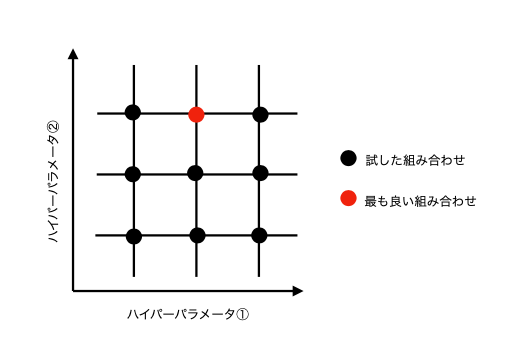

この試験では下記の2つのハイパーパラメータについてグリッドサーチを実施し、パラメータの最適化を行っていきます。<br>

|  ハイパーパラメータ |  変数名 |　探索範囲 |
| ---- | ---- | ---- |
|  ①バッチサイズ |  batch_size | 16, 32, 64 |
|  ②フィルター数 |  filter_num  | 10, 20, 30 |

#### ①ハイパーパラメータの最適化なしでの学習
まずはハイパーパラメータの最適化を行わない状態で、バッチサイズ=16、フィルター数=30で学習を実施し、精度を確認します。

In [ ]:
np.random.seed(seed=0)
network = BatchNormConvNet(
    input_dim=(1, 28, 28), filter_num=30, output_size=10, weight_init_std=0.01
)

without_train_acc_list = []
without_test_acc_list = []
sgd = SGD(lr=0.01)
batch_size = 16

for epoch in range(20):
    perm = np.random.permutation(len(x_train_cut))

    network.set_train_flag(True)
    for idx in np.arange(0, len(perm), batch_size):
        x = x_train_cut[perm[idx : idx + batch_size]]
        t = t_train_cut[perm[idx : idx + batch_size]]

        grads = network.backward(x, t)
        sgd.update(network.params, grads)

    network.set_train_flag(False)
    y_test_cut = network.forward(x_test_cut)
    y_train_cut = network.forward(x_train_cut)
    without_train_acc_list.append(
        (y_train_cut.argmax(axis=1) == t_train_cut.argmax(axis=1)).mean()
    )
    without_test_acc_list.append(
        (y_test_cut.argmax(axis=1) == t_test_cut.argmax(axis=1)).mean()
    )

    print(
        f"EPOCH {epoch + 1} | TRAIN_ACCURACY {without_train_acc_list[-1]:.2%} | TEST_ACCURACY {without_test_acc_list[-1]:.2%}"
    )

#### ②グリッドサーチの実装
グリッドサーチのための関数を定義し、グリッドサーチを実施します。

In [ ]:
# グリッドサーチの精度を格納するリストを作成
grid_acc_list = []
np.random.seed(seed=0)


# グリッドサーチ用の関数を定義
def grid_train(batch_size, filter_num):
    """グリッドサーチ関数
    ニューラルネットワークのパラメータをグリッドサーチで最適化するための関数です。

    Args:
        batch_size (int): バッチサイズ。
        filter_num (int): 畳み込み層のフィルタ数。

    Returns:
        list: 各エポックでの検証データに対する精度リスト。

     Examples:
        以下は、バッチサイズが100、フィルタ数が30の場合のトレーニングの例です。

        >>> grid_acc_list = grid_train(batch_size=100, filter_num=30)
        >>> print(grid_acc_list)
        [0.95, 0.96, 0.97, ..., 0.98]

    Note:
        - この関数は、バッチ正規化を含む畳み込みニューラルネットワークを使用します。
        - SGD（確率的勾配降下法）を用いてネットワークのパラメータを更新します。
        - トレーニングと検証を繰り返し、各エポックでの検証データに対する精度を計算します。
        - ネットワークの学習モードとテストモードを適切に切り替えます。
    """
    network = BatchNormConvNet(
        input_dim=(1, 28, 28), output_size=10, filter_num=filter_num
    )
    sgd = SGD(lr=0.01)
    for epoch in range(15):
        perm = np.random.permutation(len(x_train_cut))
        network.set_train_flag(True)
        for idx in np.arange(0, len(perm), batch_size):
            x = x_train_cut[perm[idx : idx + batch_size]]
            t = t_train_cut[perm[idx : idx + batch_size]]
            grads = network.backward(x, t)
            sgd.update(network.params, grads)
        network.set_train_flag(False)
        y_val_cut = network.forward(x_val_cut)
        grid_acc_list.append(
            (y_val_cut.argmax(axis=1) == t_val_cut.argmax(axis=1)).mean()
        )
    return grid_acc_list


# ハイパーパラメータのグリッドサーチ
acc = 0

for batch_size in [16, 32, 64]:
    for filter_num in [10, 20, 30]:
        grid_acc_list = grid_train(batch_size, filter_num)
        grid_acc = grid_acc_list[-1]
        if grid_acc > acc:
            acc = grid_acc
            best_filter_num = filter_num
            best_batch_size = batch_size
        print(
            f"filter_num {filter_num} | batch_size {batch_size} | ACCURACY {grid_acc_list[-1]:.2%}"
        )
print(
    "Best filter_num:"
    + str(best_filter_num)
    + "\n"
    + "Best batch_size:"
    + str(best_batch_size)
)

#### ③ハイパーパラメータの最適化ありでの学習
グリッドサーチで見つけたバッチサイズとフィルター数の最も良い組み合わせを使用し、学習を行い精度を確認します。<br>

In [ ]:
np.random.seed(seed=0)
network = BatchNormConvNet(
    input_dim=(1, 28, 28), output_size=10, filter_num=best_filter_num
)

with_train_acc_list = []
with_test_acc_list = []
sgd = SGD(lr=0.01)
batch_size = best_batch_size


for epoch in range(20):
    perm = np.random.permutation(len(x_train_cut))

    network.set_train_flag(True)
    for idx in np.arange(0, len(perm), batch_size):
        x = x_train_cut[perm[idx : idx + batch_size]]
        t = t_train_cut[perm[idx : idx + batch_size]]

        grads = network.backward(x, t)
        sgd.update(network.params, grads)

    network.set_train_flag(False)
    y_test_cut = network.forward(x_test_cut)
    y_train_cut = network.forward(x_train_cut)
    with_train_acc_list.append(
        (y_train_cut.argmax(axis=1) == t_train_cut.argmax(axis=1)).mean()
    )
    with_test_acc_list.append(
        (y_test_cut.argmax(axis=1) == t_test_cut.argmax(axis=1)).mean()
    )

    print(
        f"EPOCH {epoch + 1} | TRAIN_ACCURACY {with_train_acc_list[-1]:.2%} | TEST_ACCURACY {with_test_acc_list[-1]:.2%}"
    )

#### 精度比較
- ハイパーパラメータの最適化を行なったことによる精度の比較を行います。
- 学習データの予測精度とテストデータの予測精度を確認すると、パラメータの最適化を行わなかったモデル(Without tuning)より、最適化を行なったモデルの方(With tuning)が両者の差が小さくなっており、過学習が収まっていることがわかります。

In [ ]:
# 精度比較の可視化
n_epoch = 20
x = range(n_epoch)
fig = plt.figure(figsize=[15, 6])
without_tuning = fig.add_subplot(1, 2, 1, title="Without tuning")
with_tuning = fig.add_subplot(1, 2, 2, title="With tuning")

plt.suptitle("Accuracy comparison", fontsize=18)

without_tuning.plot(x, without_train_acc_list, color="tomato")
without_tuning.plot(x, without_test_acc_list, color="turquoise")
without_tuning.set_xlabel("epoch")
without_tuning.set_ylabel("accuracy")
without_tuning.set_ylim([0.6, 1])
without_tuning.legend(["TRAIN", "TEST"])

with_tuning.plot(x, with_train_acc_list, color="tomato")
with_tuning.plot(x, with_test_acc_list, color="turquoise")
with_tuning.set_xlabel("epoch")
with_tuning.set_ylabel("accuracy")
with_tuning.set_ylim([0.6, 1])
with_tuning.legend(["TRAIN", "TEST"])

plt.tight_layout()
plt.show()

## 補足

### Lpプーリングについて
 **プーリング** とは縦横方向の空間を小さくする演算のことで、主に「 **最大値プーリング** 」と「 **平均プーリング** 」があります。<br>
最大値プーリングは各領域での最大値を取り出し、平均プーリングは各領域での平均値を計算します。<br>
画像認識の分野では主に最大値プーリングが使われます。<br>

またプーリングの一般化した表記として、「 **Lpプーリング** 」が定義されます。<br>
Lpプーリングでは各領域の値をそれぞれp乗し、その平均のp乗根を計算します。<br>
Lpプーリングはp=1のとき平均プーリングとなり、pの増加に伴い最大値プーリングの近づき、p=∞のとき最大値プーリングに一致します。

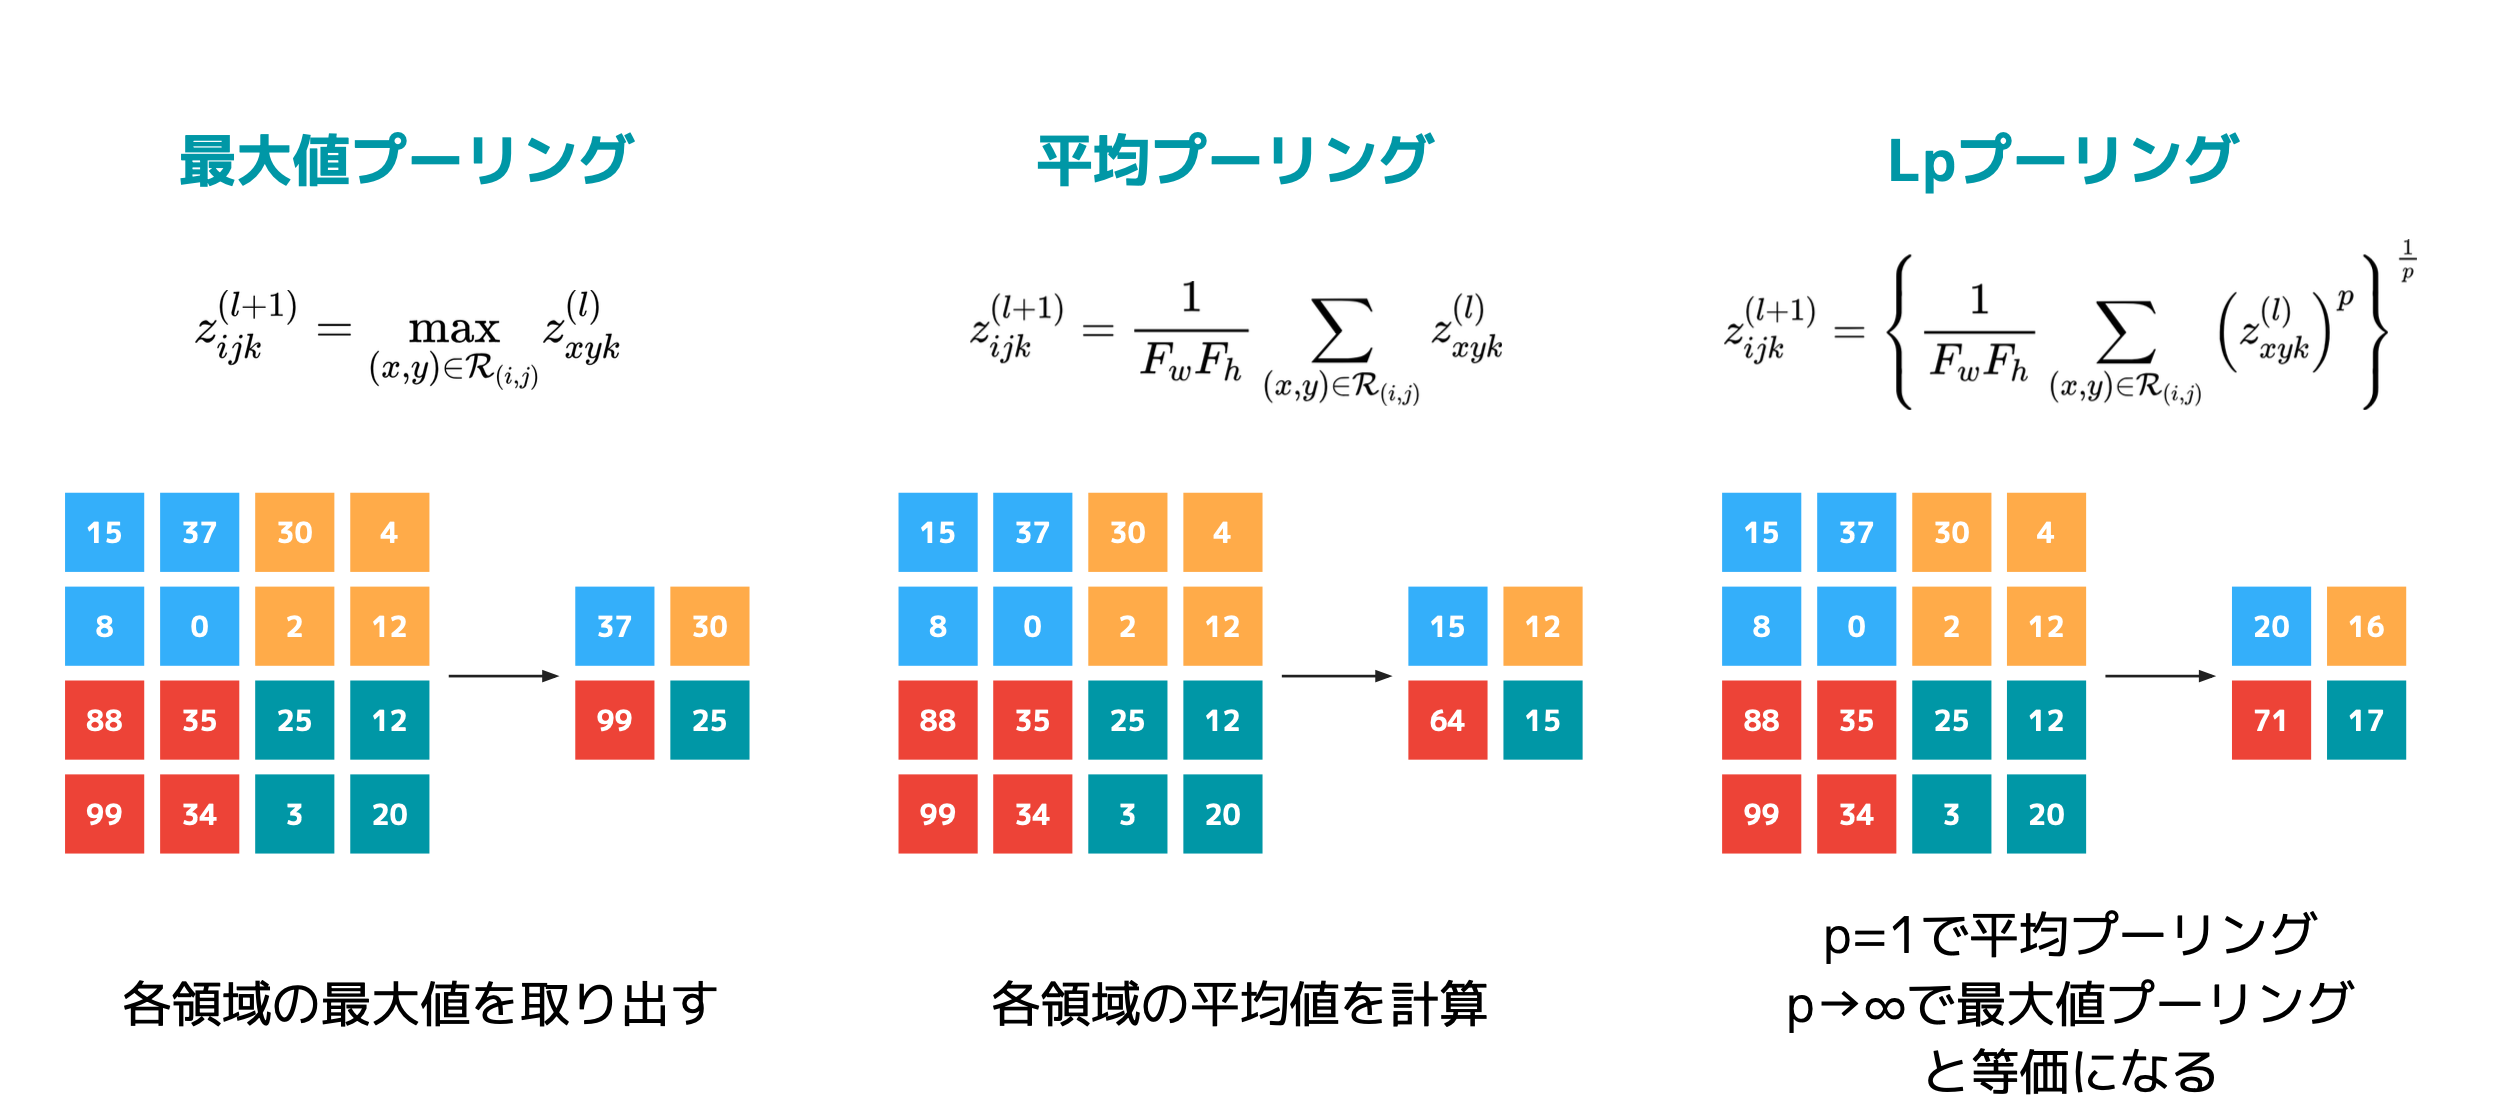

### Global Average Poolingについて
「 **Global Average Pooling(GAP)** 」ではCNNの出力側の結合層をプーリングに置き換え、各チャンネルごとに全画素の平均を取ります。

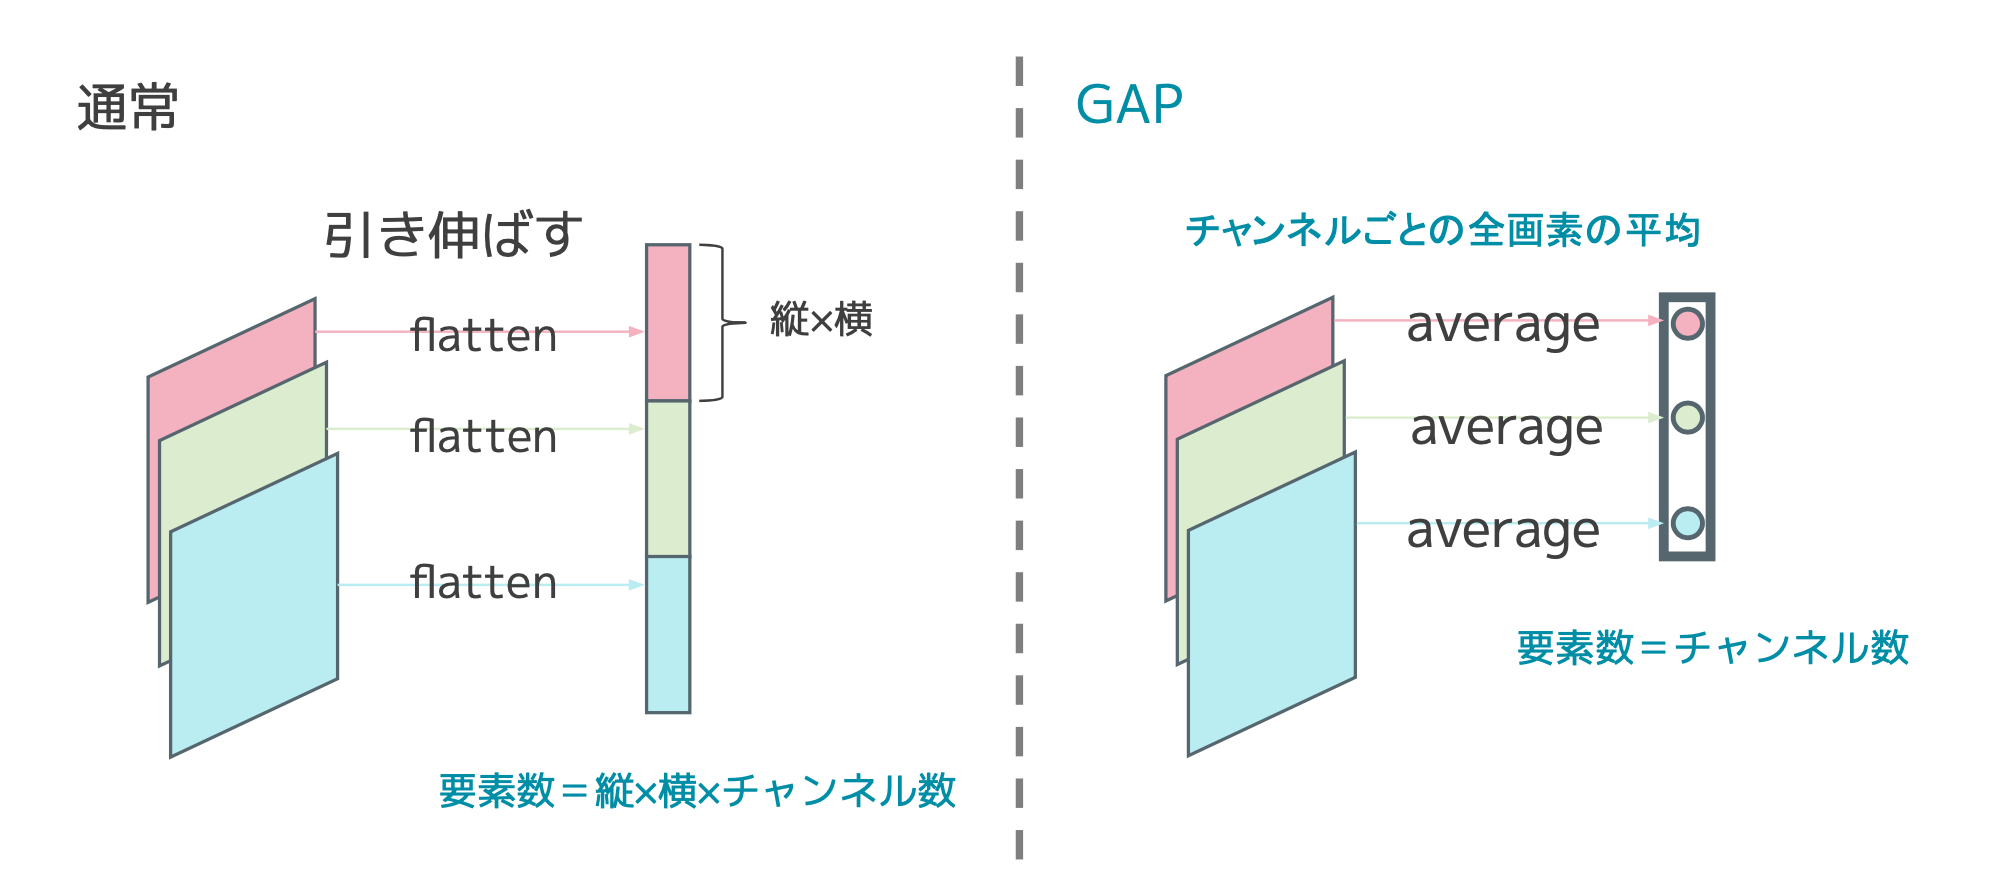



これにより学習パラメータ次元を大幅に削減することができ、過学習のリスクを低減する効果があります。<br>
GAPは主にGoogLeNetで使用されています。



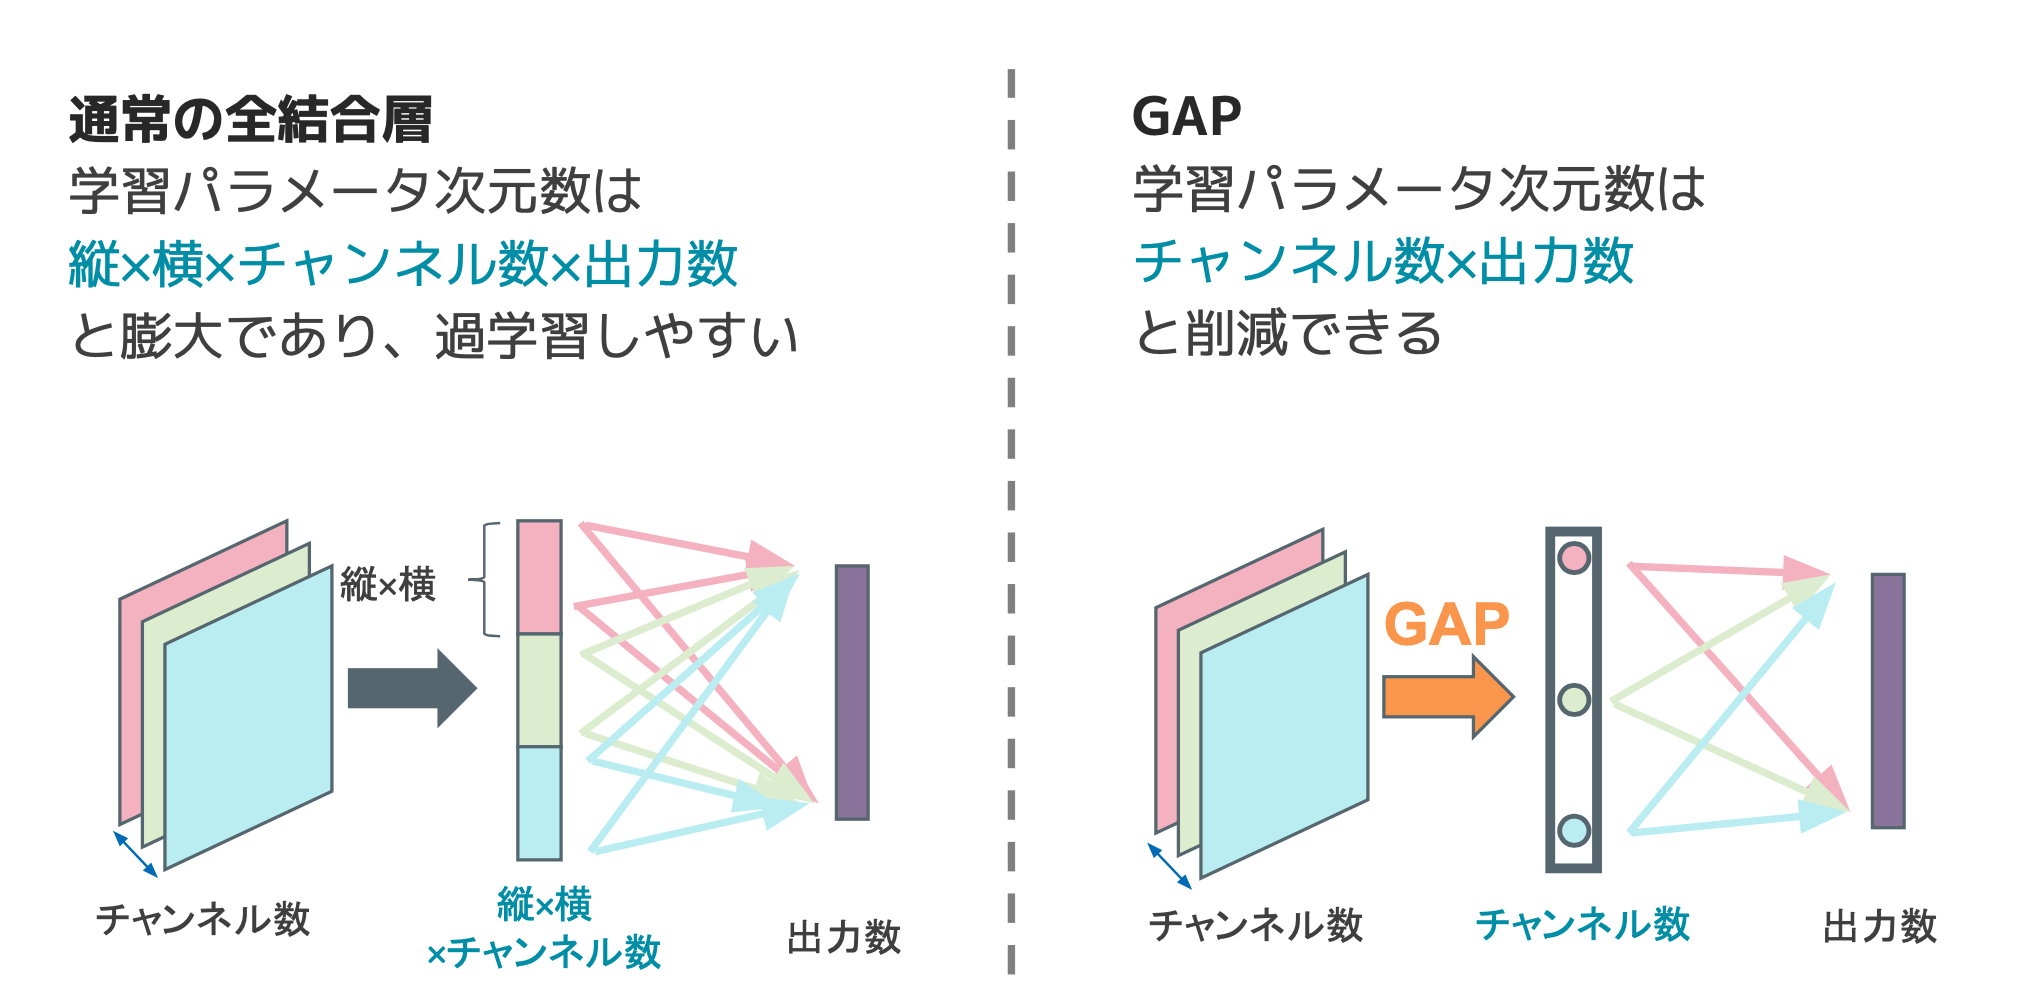